## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, unnormalize
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np
import joblib

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
# '../../data/main/gene_embeddings.parquet')
MAXGENES = 5000
MAXCELLS = 1024
model = scPrint.load_from_checkpoint(
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None, )#organisms=['NCBITaxon:9606','NCBITaxon:10090'])
# ../data/temp/o2uniqsx/epoch=18-step=133000.ckpt
metrics = {}


2024-06-27 17:51:19,511:INFO - Created a temporary directory at /local/scratch/tmp/tmpstpz63y2


2024-06-27 17:51:19,513:INFO - Writing /local/scratch/tmp/tmpstpz63y2/_remote_module_non_scriptable.py


RuntimeError caught: scPrint is not attached to a `Trainer`.


In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,do_postp=False, min_valid_genes_id=MAXGENES, min_dataset_size=64)

# han / human

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining


filtered out 0 cells, 5520 renamining


Removed 0 genes.


startin QC


Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [6]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.038948387096774194 
recall:  1.0 
random precision: 0.03895617833244068



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2184.24it/s]

Area Under Precision-Recall Curve (AUPRC):  0.06953468187956718
EPR: 2.978185129033612


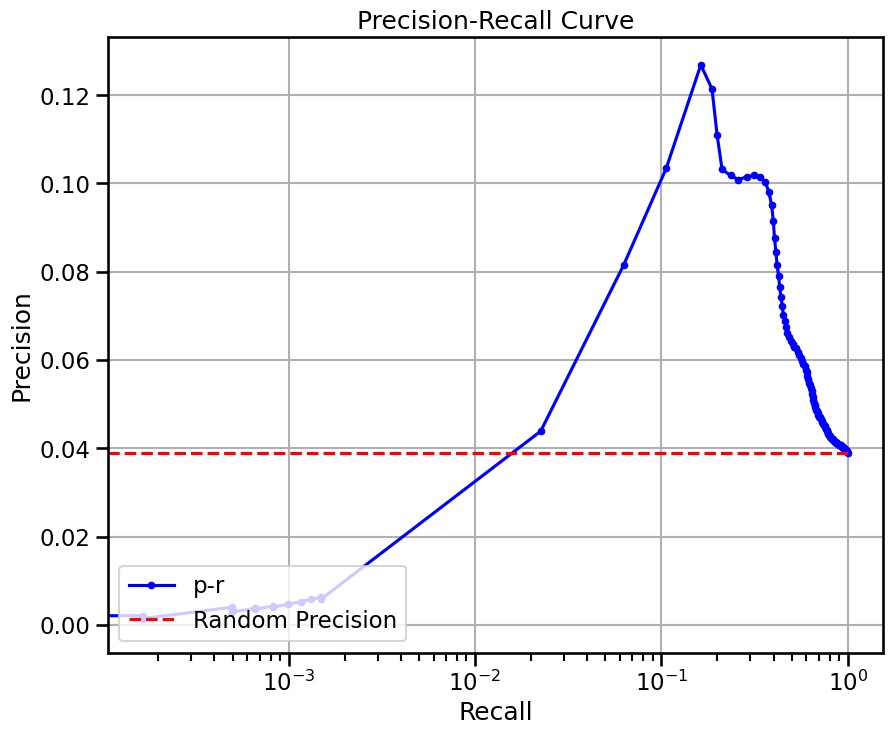

In [7]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


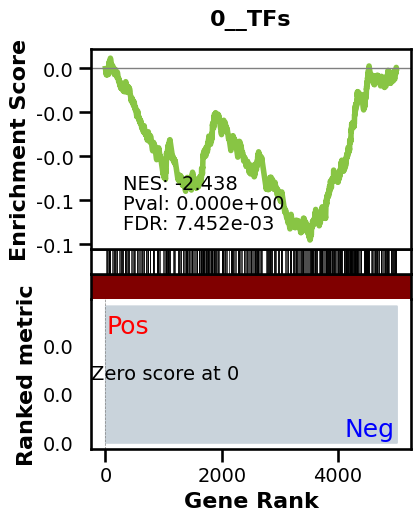

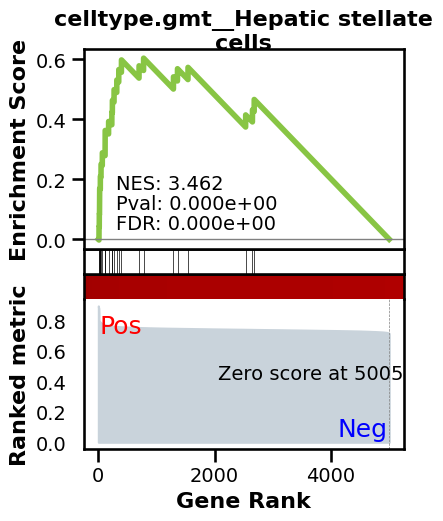

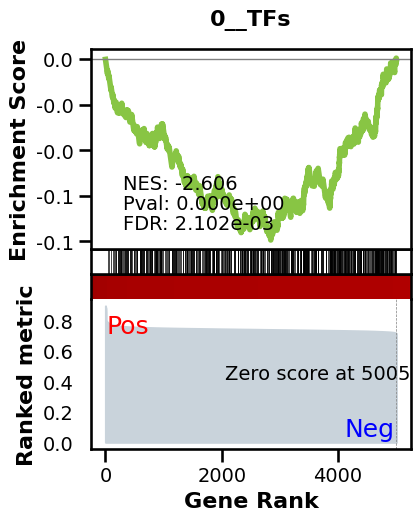

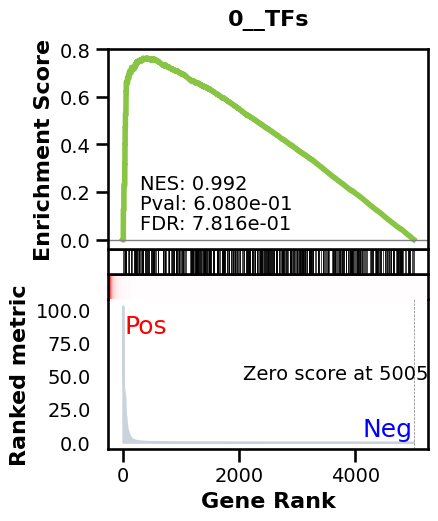

_________________________________________
TF specific enrichment


found some significant results for  23.636363636363637 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 45.61it/s]


  8%|▊         | 10/128 [00:00<00:02, 45.72it/s]


 12%|█▏        | 15/128 [00:00<00:02, 45.65it/s]


 16%|█▌        | 20/128 [00:00<00:02, 45.66it/s]


 20%|█▉        | 25/128 [00:00<00:02, 45.73it/s]


 23%|██▎       | 30/128 [00:00<00:02, 45.71it/s]


 27%|██▋       | 35/128 [00:00<00:02, 45.68it/s]


 31%|███▏      | 40/128 [00:00<00:01, 45.64it/s]


 35%|███▌      | 45/128 [00:00<00:01, 45.64it/s]


 39%|███▉      | 50/128 [00:01<00:01, 45.62it/s]


 43%|████▎     | 55/128 [00:01<00:01, 45.83it/s]


 47%|████▋     | 60/128 [00:01<00:01, 45.95it/s]


 51%|█████     | 65/128 [00:01<00:01, 46.04it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 45.86it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 45.78it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 45.75it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 45.77it/s]


 70%|███████   | 90/128 [00:01<00:00, 45.69it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 45.61it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 45.59it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 45.58it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 45.49it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 45.55it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 45.56it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 45.51it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:02<00:00, 45.65it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0018056727840080483


EPR: 2.0321305173018605


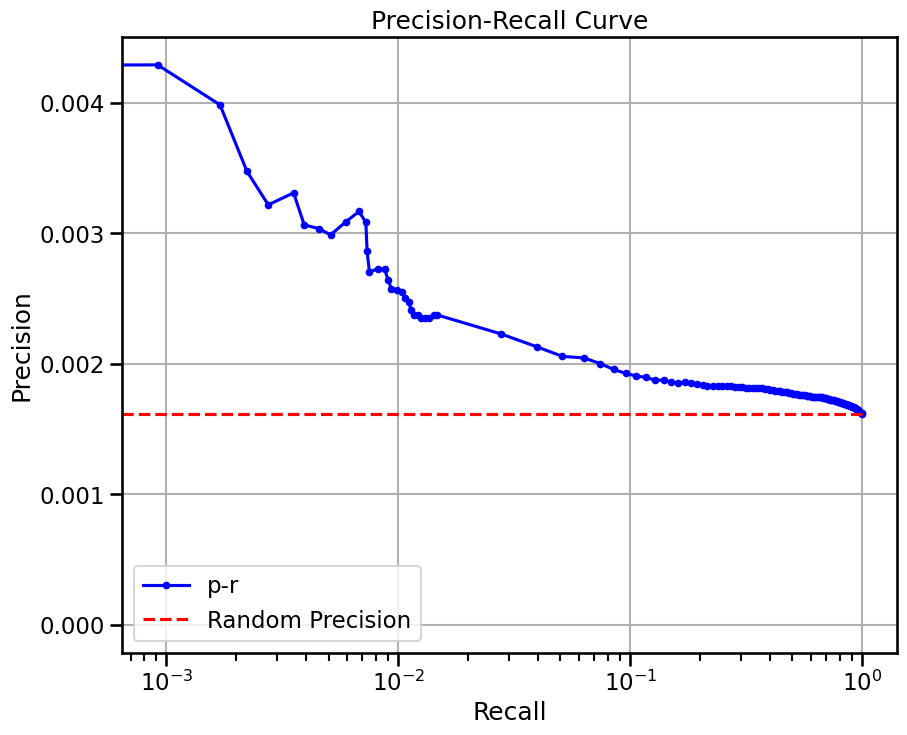

In [8]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 38%|███▊      | 49/128 [00:00<00:00, 488.15it/s]


 77%|███████▋  | 98/128 [00:00<00:00, 486.41it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 485.44it/s]

Area Under Precision-Recall Curve (AUPRC):  0.29464485128069495
EPR: 1.1545093654468563


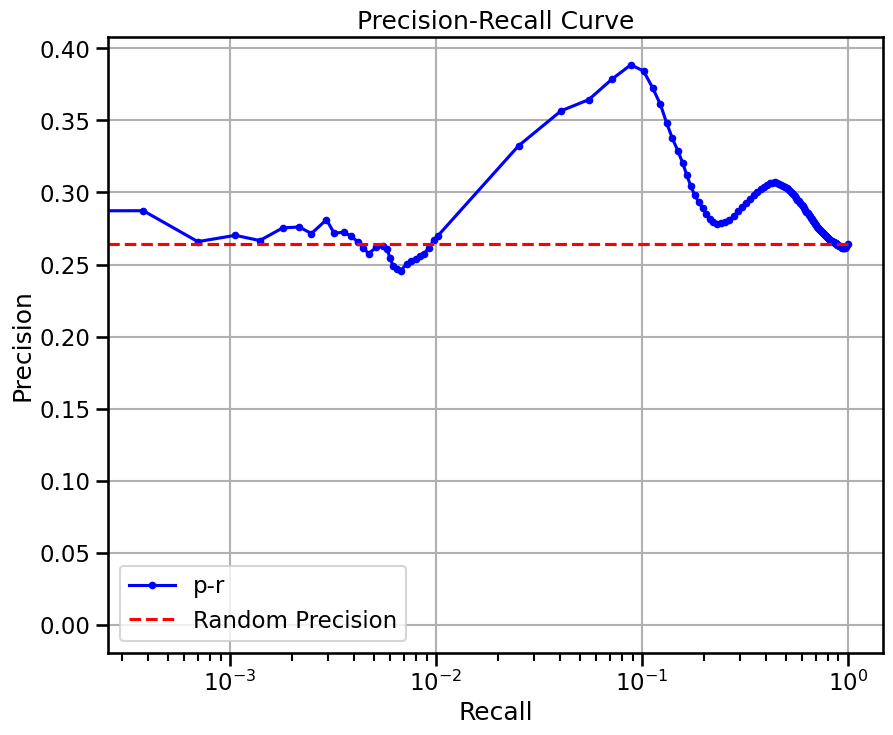

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 33%|███▎      | 42/128 [00:00<00:00, 410.64it/s]


 66%|██████▌   | 84/128 [00:00<00:00, 409.88it/s]


 98%|█████████▊| 126/128 [00:00<00:00, 410.07it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 409.01it/s]

Area Under Precision-Recall Curve (AUPRC):  0.09642728625989647
EPR: 1.9393293614430762


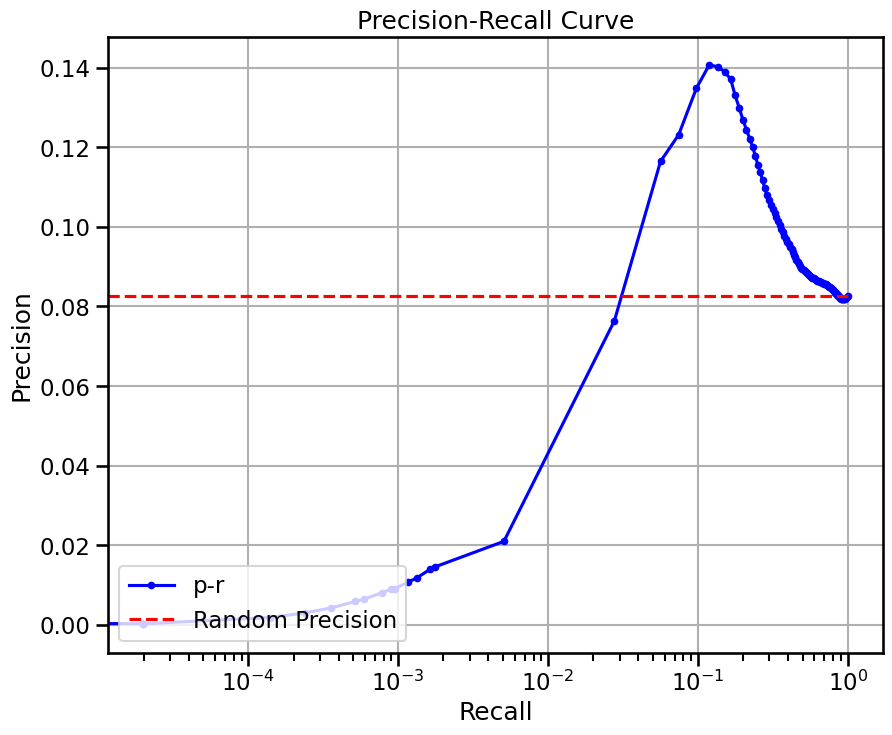

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="full")

true elem 22920 ...


doing classification....


metrics {'used_heads': 101, 'precision': 0.005585292064230859, 'random_precision': 0.00165958553348804, 'recall': 0.01019108280254777, 'predicted_true': 4297.0, 'number_of_true': 2355.0, 'epr': 3.874463072539996}


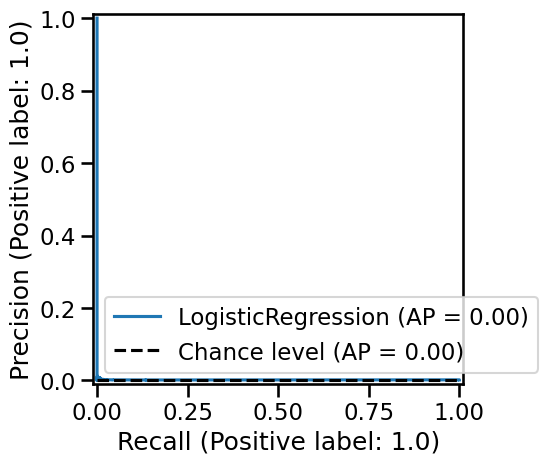

In [12]:
grn.varp["GRN"] = grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={1: 200, 0: 1}, shuffle=True)

In [13]:
# Save the clf_omni classifier to a file
joblib.dump(clf_omni, 'clf_omni_model.pkl')

['clf_omni_model.pkl']

precision:  0.038948387096774194 
recall:  1.0 
random precision: 0.03895617833244068



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2209.04it/s]

Area Under Precision-Recall Curve (AUPRC):  0.05101876149961283
EPR: 4.779300230434627


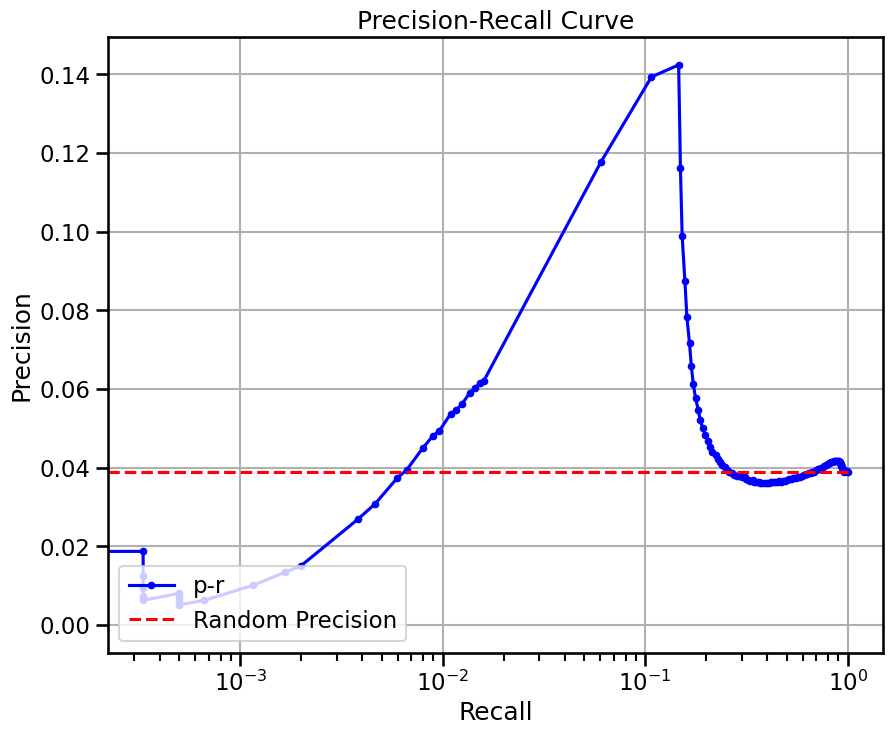

In [14]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_omni_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


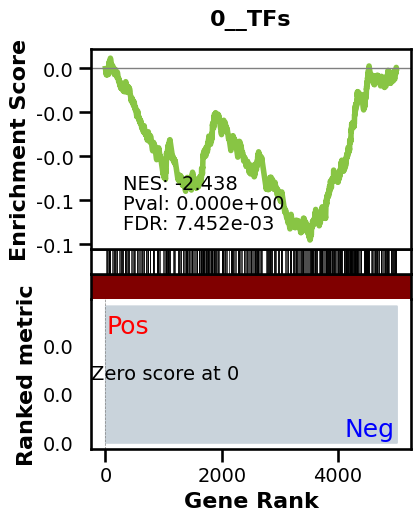

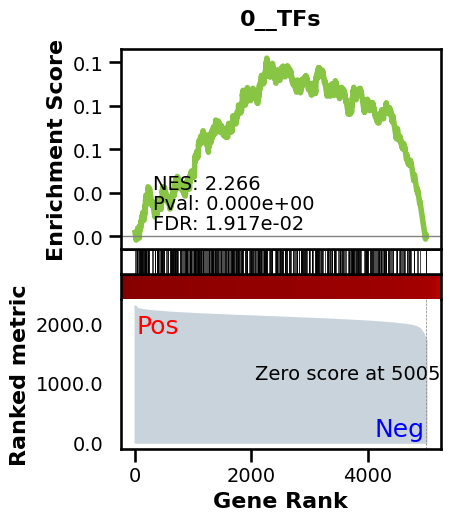

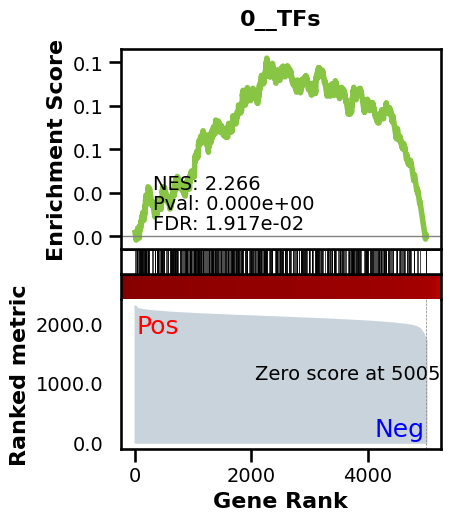

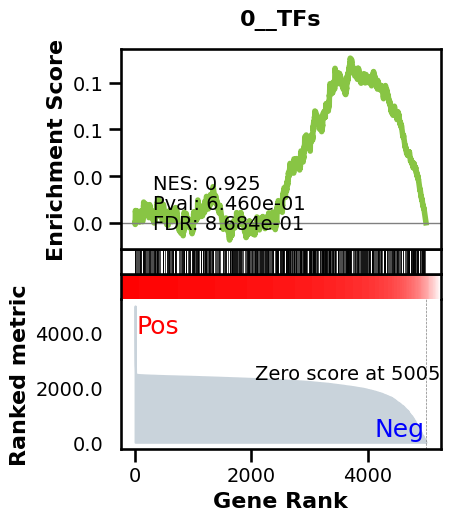

_________________________________________
TF specific enrichment


found some significant results for  3.6363636363636362 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  3%|▎         | 4/128 [00:00<00:03, 39.25it/s]


  6%|▋         | 8/128 [00:00<00:03, 39.27it/s]


 10%|█         | 13/128 [00:00<00:02, 39.58it/s]


 13%|█▎        | 17/128 [00:00<00:02, 39.69it/s]


 16%|█▋        | 21/128 [00:00<00:02, 39.76it/s]


 20%|██        | 26/128 [00:00<00:02, 39.93it/s]


 23%|██▎       | 30/128 [00:00<00:02, 39.84it/s]


 27%|██▋       | 34/128 [00:00<00:02, 39.87it/s]


 30%|██▉       | 38/128 [00:00<00:02, 39.88it/s]


 33%|███▎      | 42/128 [00:01<00:02, 39.86it/s]


 36%|███▌      | 46/128 [00:01<00:02, 39.88it/s]


 39%|███▉      | 50/128 [00:01<00:01, 39.76it/s]


 42%|████▏     | 54/128 [00:01<00:01, 39.74it/s]


 45%|████▌     | 58/128 [00:01<00:01, 39.74it/s]


 48%|████▊     | 62/128 [00:01<00:01, 39.71it/s]


 52%|█████▏    | 67/128 [00:01<00:01, 39.90it/s]


 55%|█████▌    | 71/128 [00:01<00:01, 39.90it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 39.91it/s]


 62%|██████▏   | 79/128 [00:01<00:01, 39.92it/s]


 66%|██████▌   | 84/128 [00:02<00:01, 40.06it/s]


 70%|██████▉   | 89/128 [00:02<00:00, 40.02it/s]


 73%|███████▎  | 94/128 [00:02<00:00, 39.98it/s]


 77%|███████▋  | 98/128 [00:02<00:00, 39.94it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 39.76it/s]


 83%|████████▎ | 106/128 [00:02<00:00, 39.72it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 39.63it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 39.72it/s]


 94%|█████████▍| 120/128 [00:03<00:00, 39.93it/s]


 98%|█████████▊| 125/128 [00:03<00:00, 40.06it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:03<00:00, 39.85it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0016597335453934078


EPR: 5.116867859465253


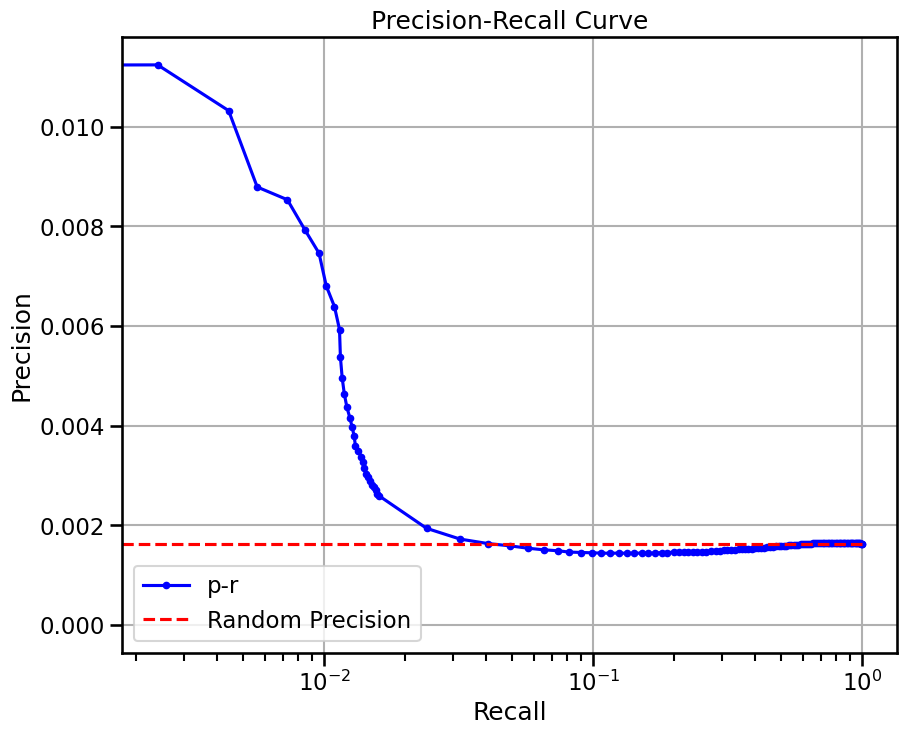

In [15]:
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_omni_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 37%|███▋      | 47/128 [00:00<00:00, 462.56it/s]


 73%|███████▎  | 94/128 [00:00<00:00, 461.46it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 460.44it/s]

Area Under Precision-Recall Curve (AUPRC):  0.24434708945360423
EPR: 0.7665527604309154


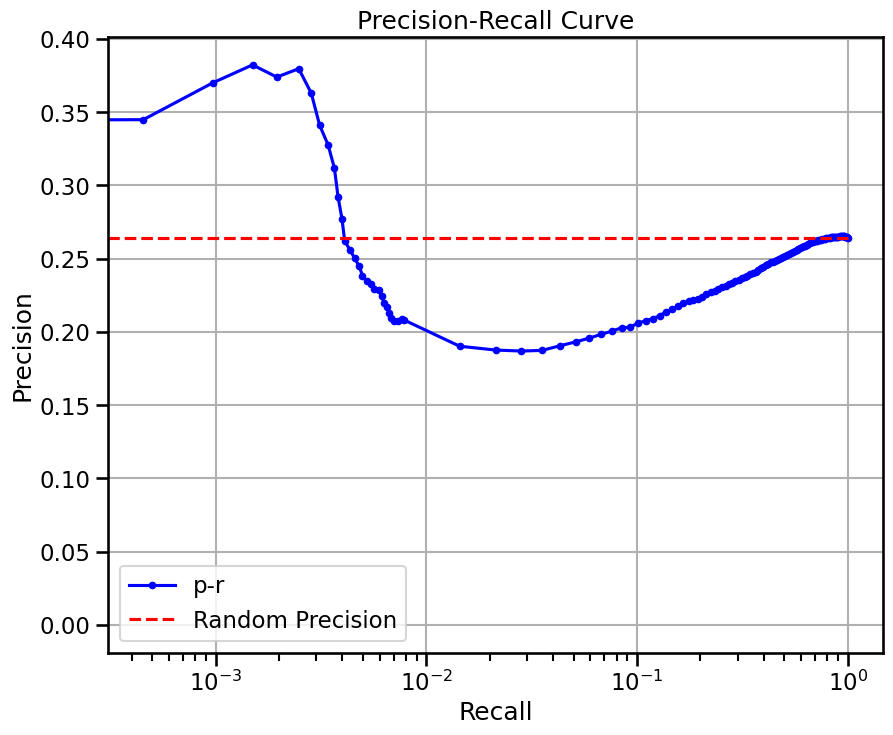

In [16]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_omni_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|███       | 39/128 [00:00<00:00, 386.53it/s]


 61%|██████    | 78/128 [00:00<00:00, 385.18it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 385.84it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 384.85it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07761441980402883
EPR: 0.7330050915595431


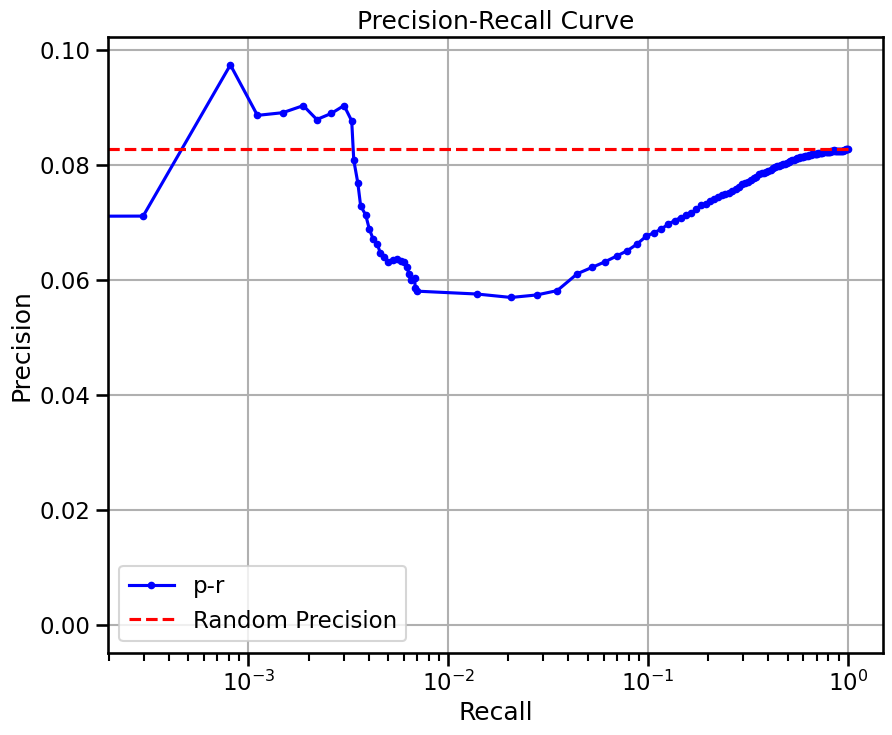

In [17]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_omni_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (122, 5000, 128)
true elem 50452 ...
doing classification....


metrics {'used_heads': 20, 'precision': 0.10584687991609859, 'random_precision': 0.08208196721311475, 'recall': 0.8062712202915918, 'predicted_true': 190700.0, 'number_of_true': 25035.0, 'epr': 3.9168286337960083}


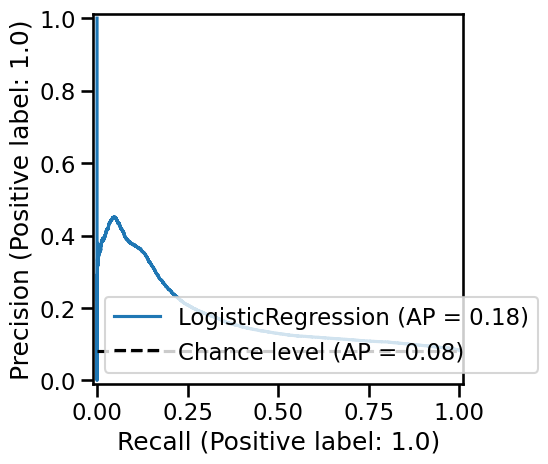

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|███       | 39/128 [00:00<00:00, 382.92it/s]


 61%|██████    | 78/128 [00:00<00:00, 383.79it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 384.04it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 383.39it/s]

Area Under Precision-Recall Curve (AUPRC):  0.175334226332792
EPR: 3.785081109470365


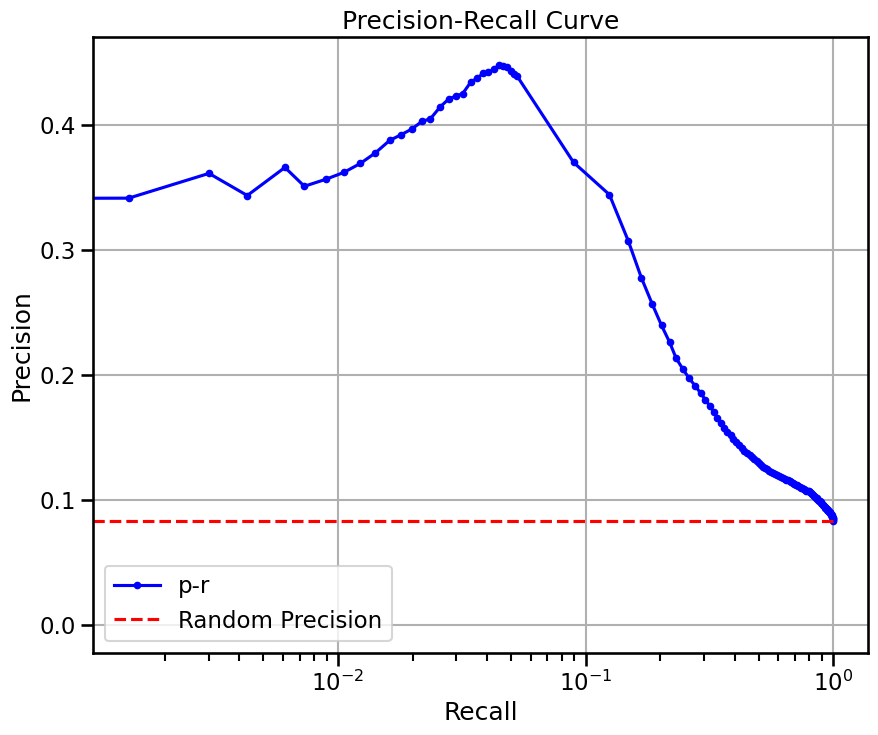

In [18]:
grn.varp['GRN'] = np.transpose(grn.varp['all'], (1,0,2))
weight = int((preadata.grn.sum(1)>0).sum()* (preadata.grn.sum(0)>0).sum()/ preadata.grn.sum().sum())
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: weight, 0: 1}, shuffle=True, max_iter=500,)
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_self_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [19]:
joblib.dump(clf_self, 'clf_self_model.pkl')

['clf_self_model.pkl']

base enrichment


Top central genes: []


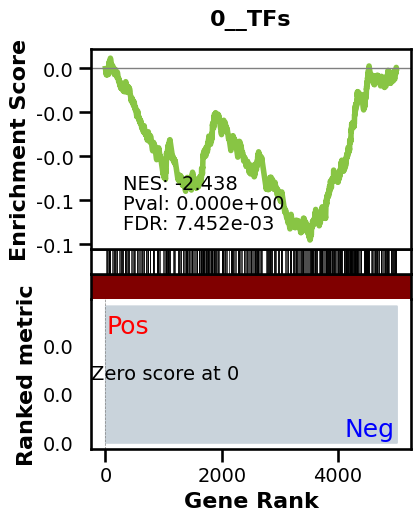

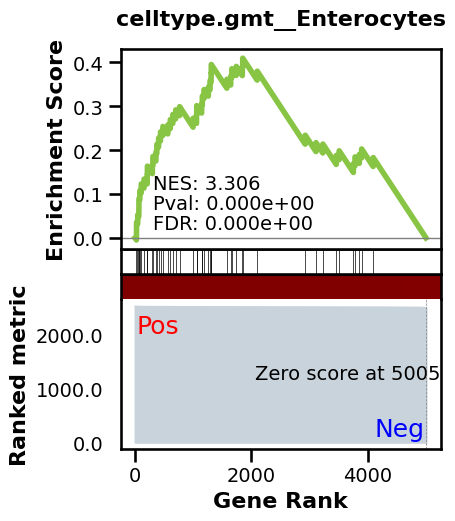

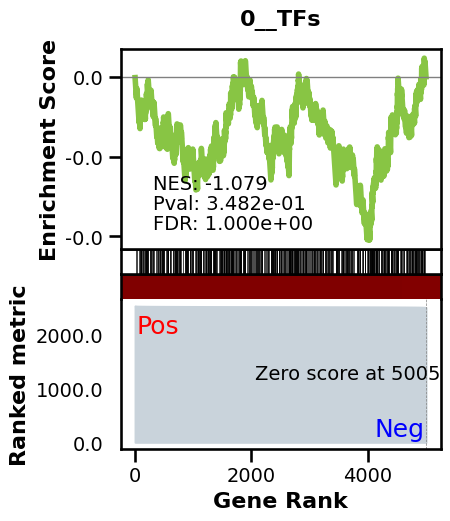

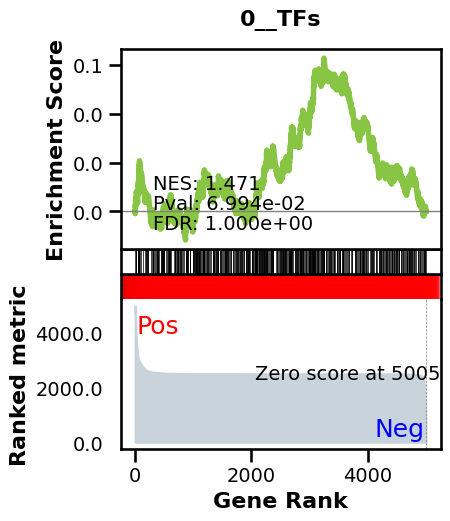

_________________________________________
TF specific enrichment


found some significant results for  12.727272727272727 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:03, 40.15it/s]


  8%|▊         | 10/128 [00:00<00:02, 39.90it/s]


 11%|█         | 14/128 [00:00<00:02, 39.81it/s]


 14%|█▍        | 18/128 [00:00<00:02, 39.82it/s]


 18%|█▊        | 23/128 [00:00<00:02, 40.01it/s]


 21%|██        | 27/128 [00:00<00:02, 39.88it/s]


 24%|██▍       | 31/128 [00:00<00:02, 39.89it/s]


 28%|██▊       | 36/128 [00:00<00:02, 39.99it/s]


 31%|███▏      | 40/128 [00:01<00:02, 39.75it/s]


 34%|███▍      | 44/128 [00:01<00:02, 39.71it/s]


 38%|███▊      | 48/128 [00:01<00:02, 39.78it/s]


 41%|████      | 52/128 [00:01<00:01, 39.56it/s]


 45%|████▍     | 57/128 [00:01<00:01, 39.64it/s]


 48%|████▊     | 62/128 [00:01<00:01, 39.82it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 39.86it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 39.89it/s]


 58%|█████▊    | 74/128 [00:01<00:01, 39.57it/s]


 61%|██████    | 78/128 [00:01<00:01, 39.64it/s]


 65%|██████▍   | 83/128 [00:02<00:01, 39.72it/s]


 68%|██████▊   | 87/128 [00:02<00:01, 39.79it/s]


 71%|███████   | 91/128 [00:02<00:00, 39.76it/s]


 75%|███████▌  | 96/128 [00:02<00:00, 39.71it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 39.68it/s]


 81%|████████▏ | 104/128 [00:02<00:00, 39.75it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 39.80it/s]


 88%|████████▊ | 112/128 [00:02<00:00, 39.83it/s]


 91%|█████████ | 116/128 [00:02<00:00, 39.86it/s]


 95%|█████████▍| 121/128 [00:03<00:00, 40.02it/s]


 98%|█████████▊| 125/128 [00:03<00:00, 39.92it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:03<00:00, 39.78it/s]

Area Under Precision-Recall Curve (AUPRC):  0.001591941934779904
EPR: 0.9450126925343056


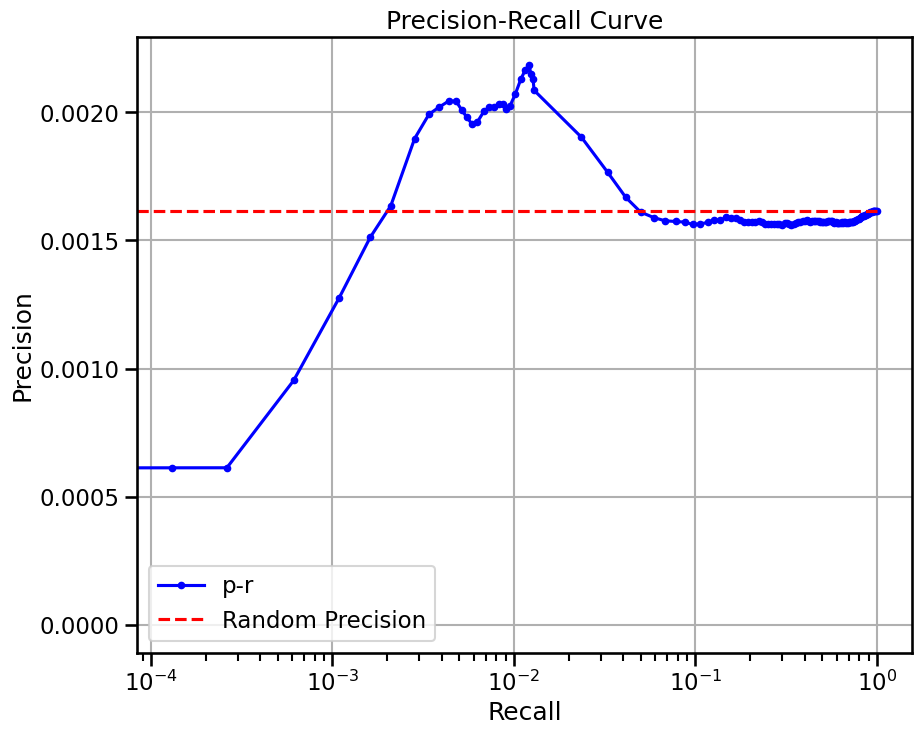

In [20]:
grn.varp['GRN'] = grn.varp['classified'].T
metrics['scprint_self_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 37%|███▋      | 47/128 [00:00<00:00, 461.11it/s]


 73%|███████▎  | 94/128 [00:00<00:00, 462.20it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 461.64it/s]

Area Under Precision-Recall Curve (AUPRC):  0.26014067801461294
EPR: 0.9227285790989448


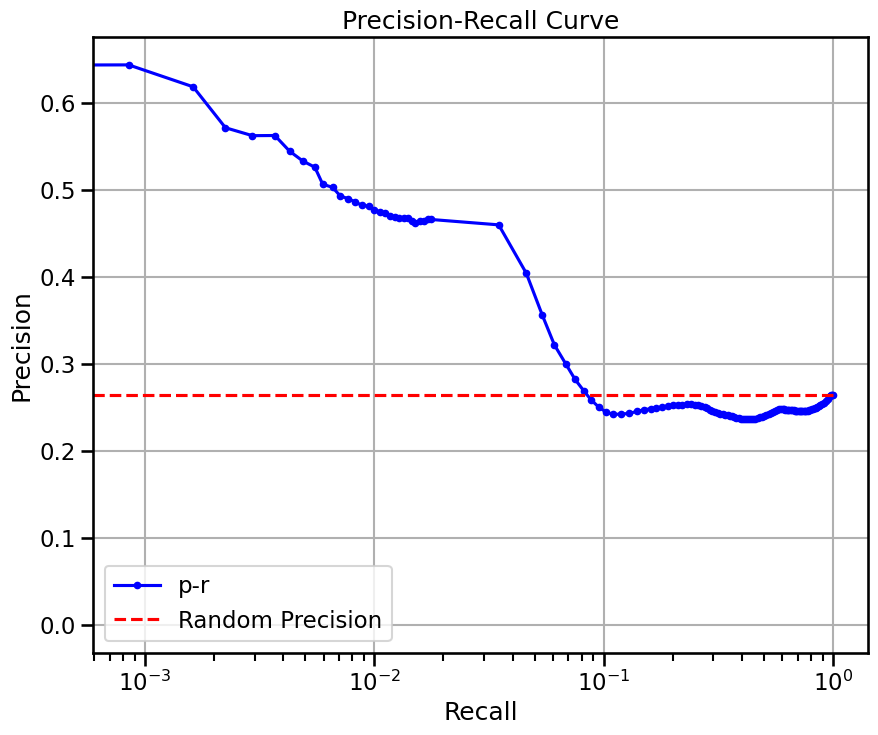

In [21]:
grn.varp['GRN'] = grn.varp['classified']
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_self_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|███       | 39/128 [00:00<00:00, 385.86it/s]


 61%|██████    | 78/128 [00:00<00:00, 385.50it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 385.51it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 385.00it/s]

Area Under Precision-Recall Curve (AUPRC):  0.175334226332792
EPR: 3.785081109470365


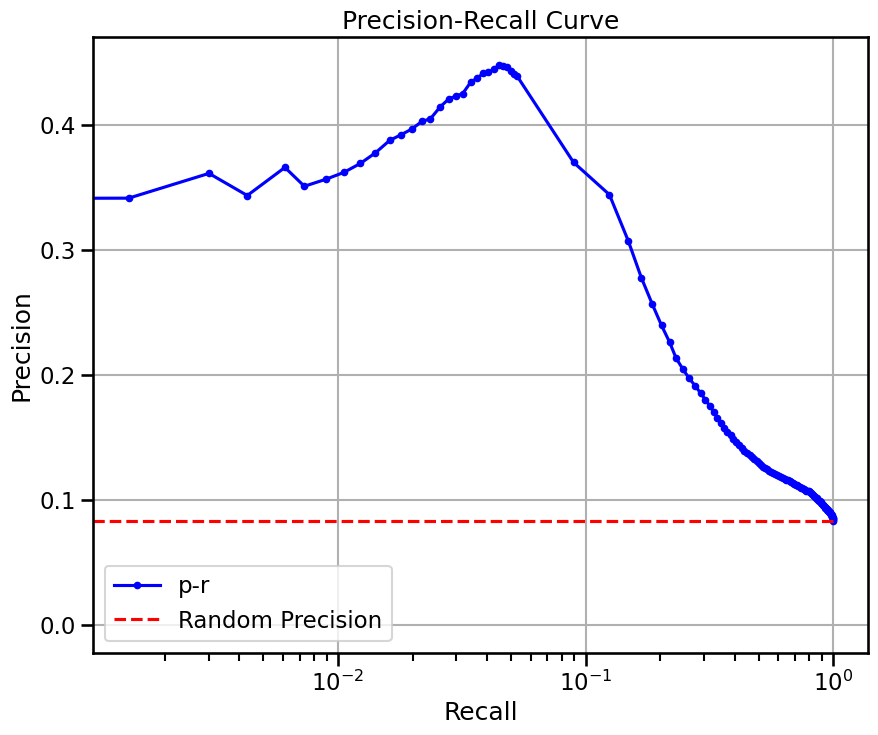

In [22]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_self_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [23]:
del grn

# mine / human

In [24]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining


filtered out 0 cells, 115 renamining
Removed 0 genes.


startin QC
Seeing 104 outliers (90.43% of total dataset):


done


(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

In [25]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 23518


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.02702970952160392 
recall:  1.0 
random precision: 0.0270359707468811



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2729.11it/s]

Area Under Precision-Recall Curve (AUPRC):  0.024383016589726053
EPR: 0.03432789372232627


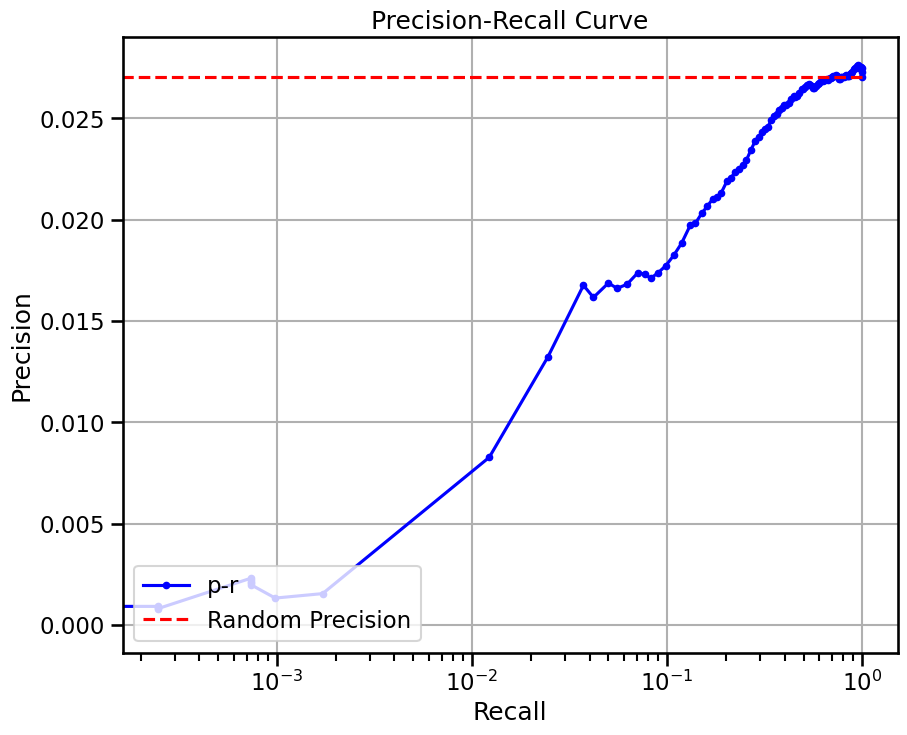

In [27]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


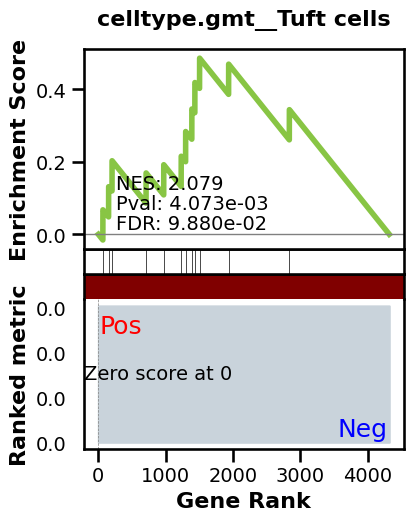

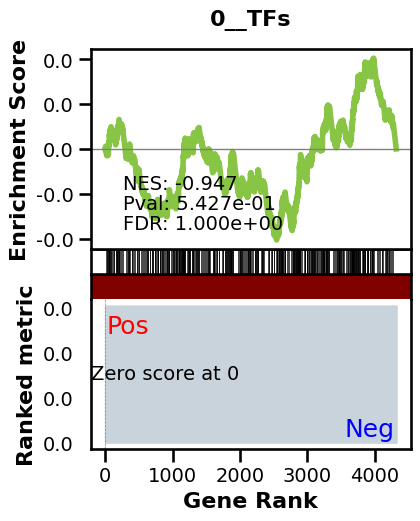

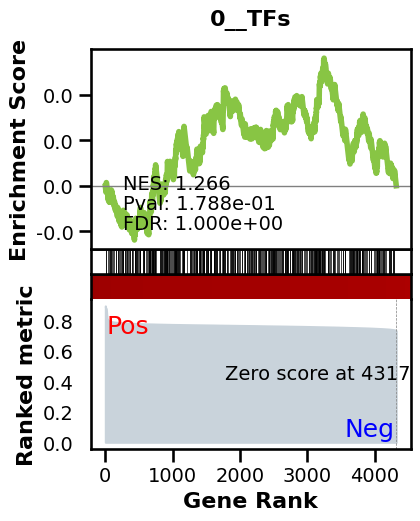

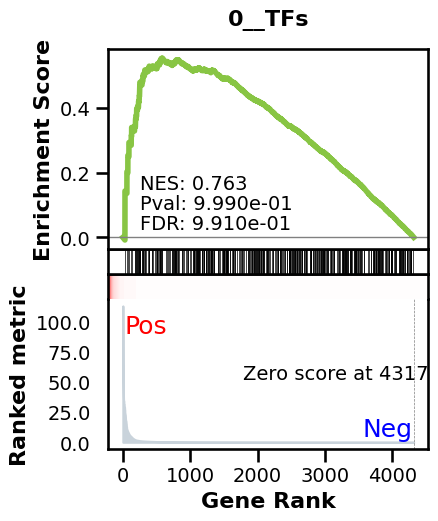

_________________________________________
TF specific enrichment


found some significant results for  31.11111111111111 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2846 genes
intersection pct: 0.6591014358499305
precision:  0.001610920679194184 
recall:  1.0 
random precision: 0.0016114869079039184



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 81.33it/s]


 14%|█▍        | 18/128 [00:00<00:01, 83.03it/s]


 21%|██        | 27/128 [00:00<00:01, 83.29it/s]


 28%|██▊       | 36/128 [00:00<00:01, 83.77it/s]


 35%|███▌      | 45/128 [00:00<00:00, 83.82it/s]


 42%|████▏     | 54/128 [00:00<00:00, 83.95it/s]


 49%|████▉     | 63/128 [00:00<00:00, 84.05it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 84.22it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 84.28it/s]


 70%|███████   | 90/128 [00:01<00:00, 84.29it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 84.08it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 84.08it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 84.17it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 84.27it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 83.90it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0018737308840721056
EPR: 1.763995803294471


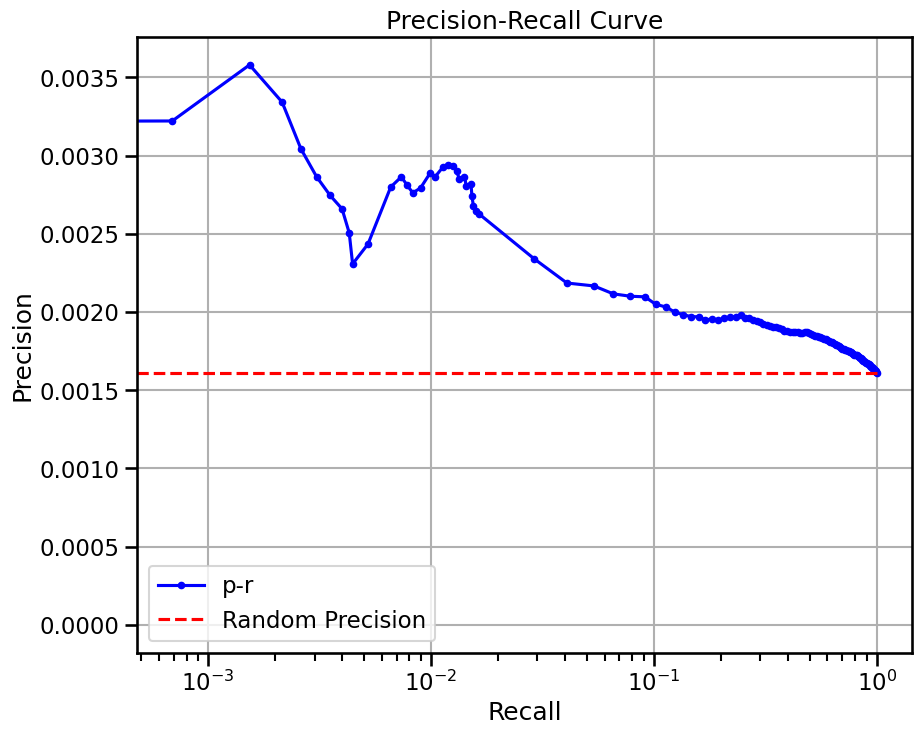

In [28]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.02702970952160392 
recall:  1.0 
random precision: 0.0270359707468811



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2661.19it/s]

Area Under Precision-Recall Curve (AUPRC):  0.022137811420500923
EPR: 0.13813426430447356


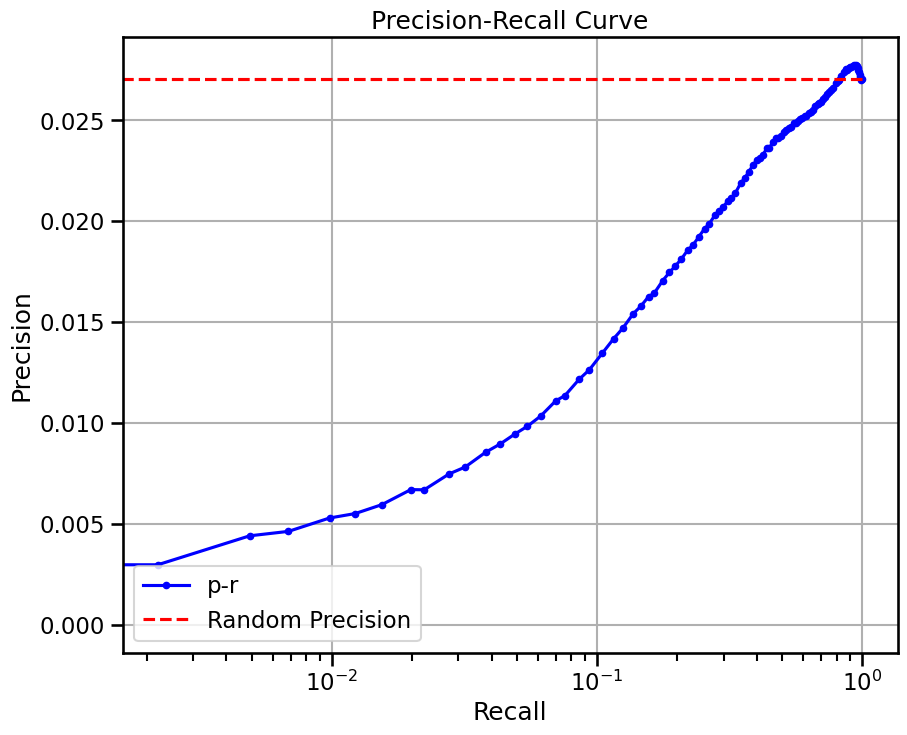

In [29]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


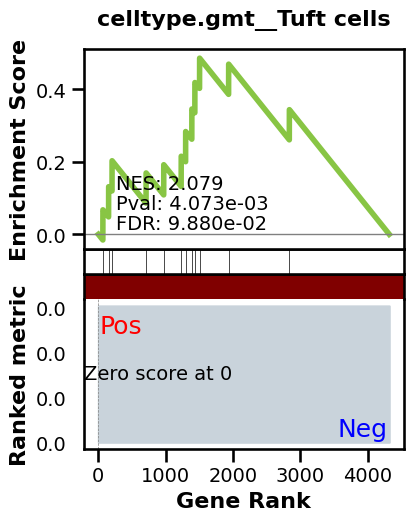

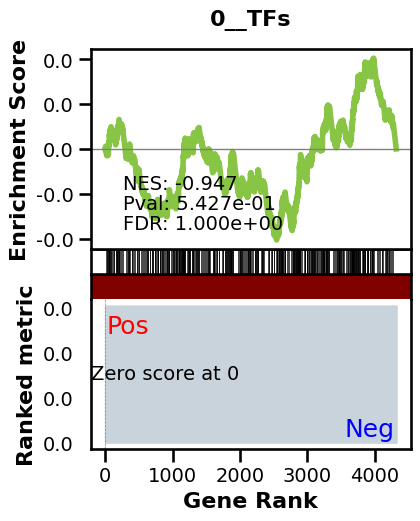

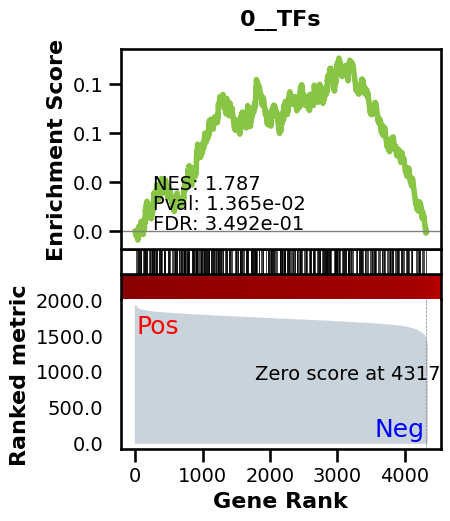

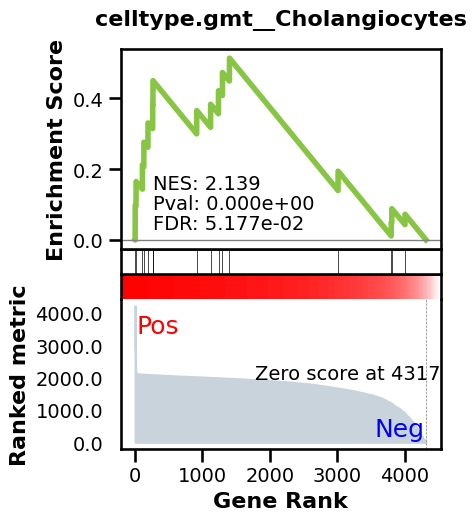

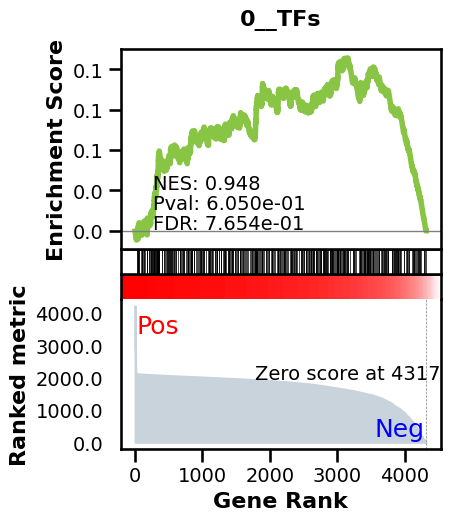

_________________________________________
TF specific enrichment


found some significant results for  4.444444444444445 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2846 genes
intersection pct: 0.6591014358499305
precision:  0.0016110004364566634 
recall:  1.0 
random precision: 0.0016114869079039184



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 72.31it/s]


 12%|█▎        | 16/128 [00:00<00:01, 72.48it/s]


 19%|█▉        | 24/128 [00:00<00:01, 73.34it/s]


 25%|██▌       | 32/128 [00:00<00:01, 73.50it/s]


 31%|███▏      | 40/128 [00:00<00:01, 73.82it/s]


 38%|███▊      | 48/128 [00:00<00:01, 73.03it/s]


 44%|████▍     | 56/128 [00:00<00:00, 73.15it/s]


 50%|█████     | 64/128 [00:00<00:00, 73.29it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 73.24it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 73.41it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 73.23it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 73.31it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 73.41it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 73.08it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 73.01it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 72.92it/s]


100%|██████████| 128/128 [00:01<00:00, 73.14it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0015615230898740986
EPR: 3.3542965333583363


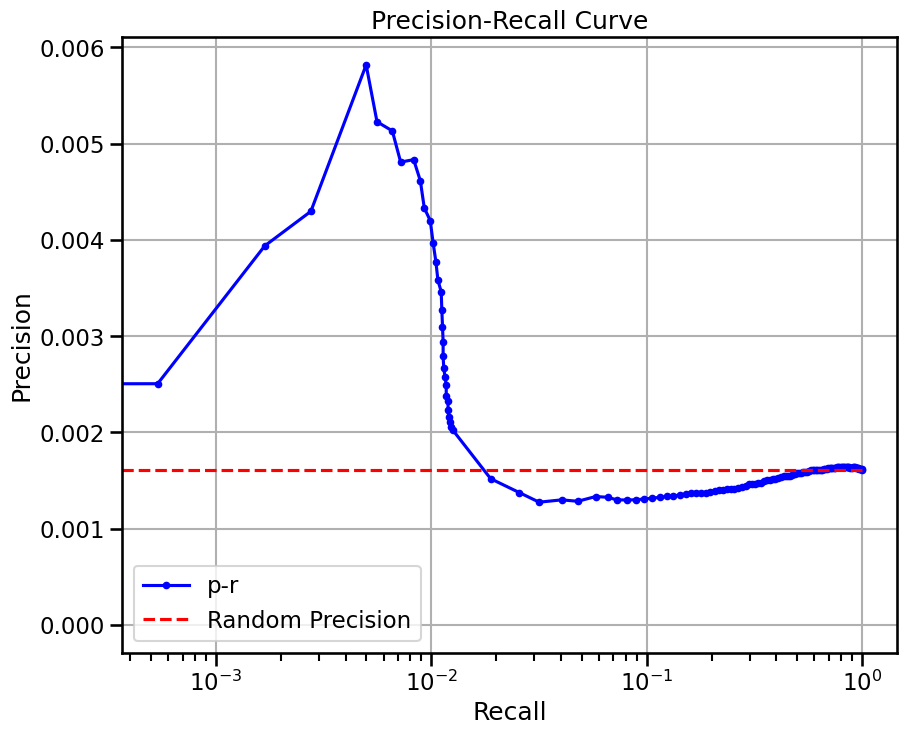

In [30]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.02702970952160392 
recall:  1.0 
random precision: 0.0270359707468811



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2649.41it/s]

Area Under Precision-Recall Curve (AUPRC):  0.041503188248301556
EPR: 2.5779886804780276


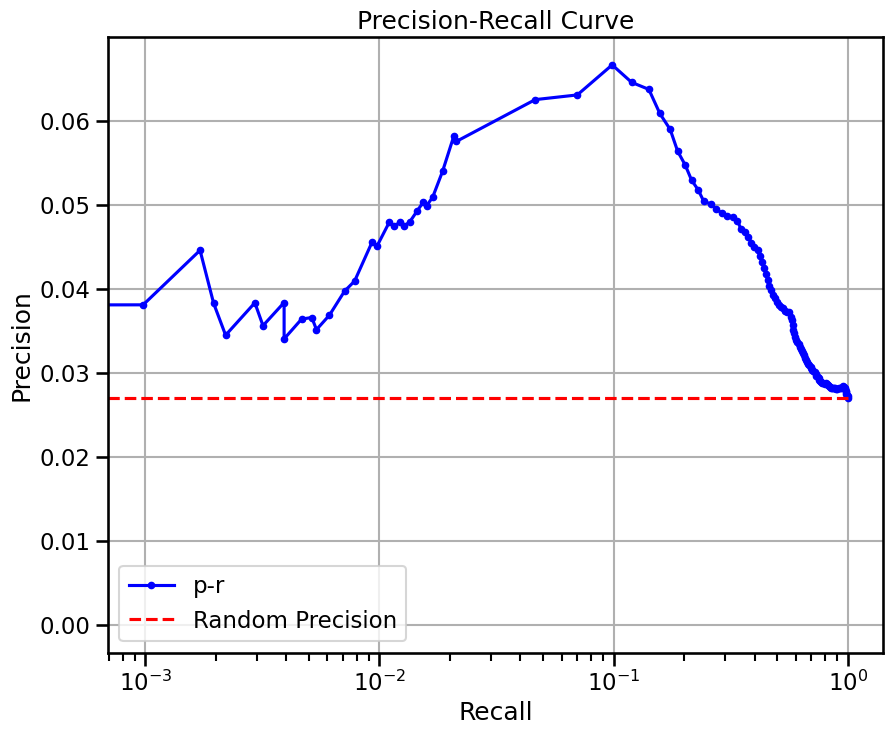

In [31]:
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


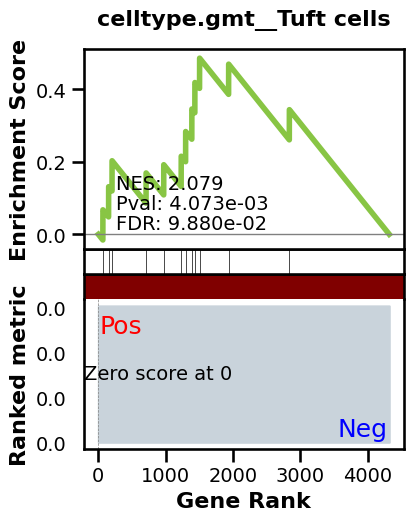

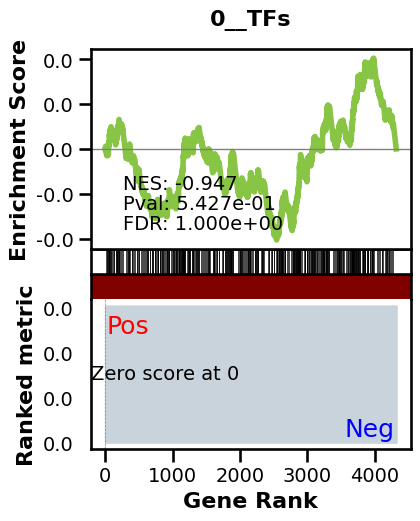

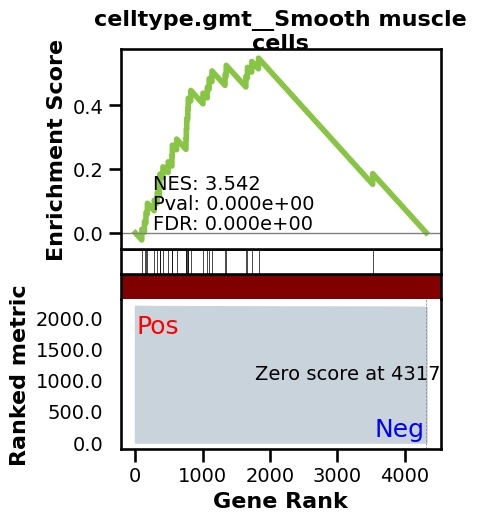

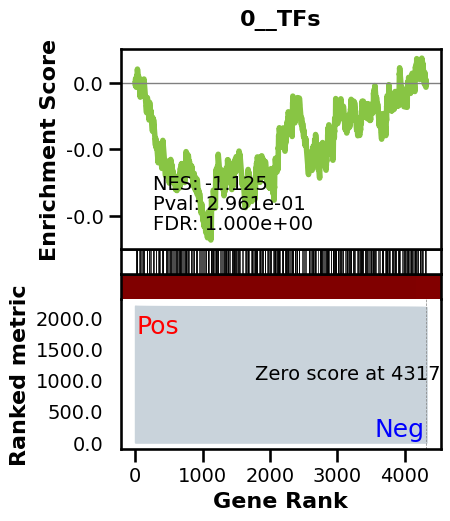

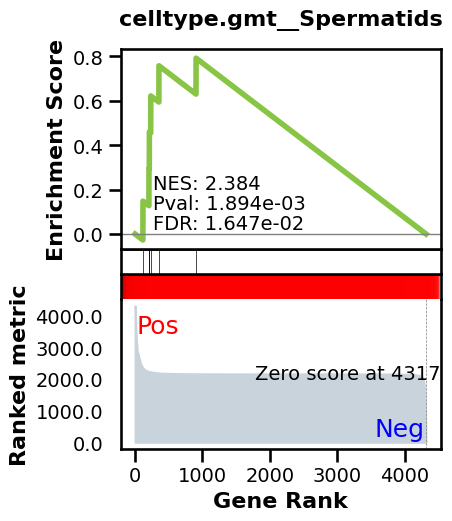

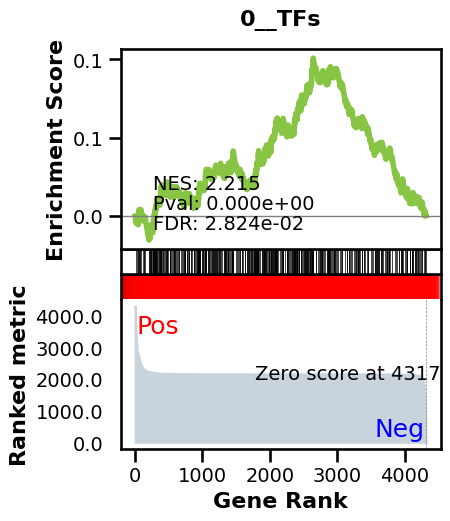

_________________________________________
TF specific enrichment


found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2846 genes
intersection pct: 0.6591014358499305
precision:  0.001610920679194184 
recall:  1.0 
random precision: 0.0016114869079039184



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 71.99it/s]


 12%|█▎        | 16/128 [00:00<00:01, 72.29it/s]


 19%|█▉        | 24/128 [00:00<00:01, 72.41it/s]


 25%|██▌       | 32/128 [00:00<00:01, 71.89it/s]


 31%|███▏      | 40/128 [00:00<00:01, 71.84it/s]


 38%|███▊      | 48/128 [00:00<00:01, 72.32it/s]


 44%|████▍     | 56/128 [00:00<00:00, 72.39it/s]


 50%|█████     | 64/128 [00:00<00:00, 72.83it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 73.15it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 72.77it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 72.96it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 72.81it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 72.97it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 73.05it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 73.04it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 72.92it/s]


100%|██████████| 128/128 [00:01<00:00, 72.68it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0015571916797868536
EPR: 0.569912751818765


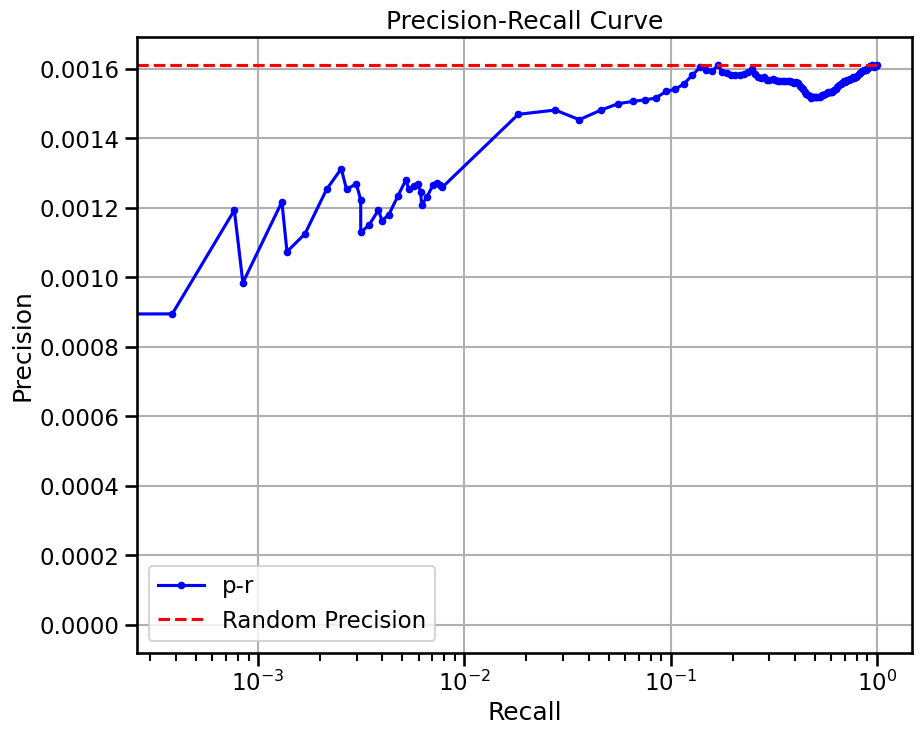

In [32]:
grn.varp['GRN'] = grn.varp['GRN'].T
metrics['scprint_self_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [33]:
del grn

In [34]:
metrics

{'scprint_mean_han_full': {'precision': 0.038948387096774194,
  'recall': 1.0,
  'rand_precision': 0.03895617833244068,
  'auprc': 0.06953468187956718,
  'epr': 2.978185129033612},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Adipose progenitor cells',
   'cellty

## tran / mouse

In [35]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining


filtered out 0 cells, 2369 renamining
Removed 0 genes.


startin QC
Seeing 91 outliers (3.84% of total dataset):


done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

In [36]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 6435


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2218.09it/s]

Area Under Precision-Recall Curve (AUPRC):  0.05066923677336137
EPR: 2.9838291137924227


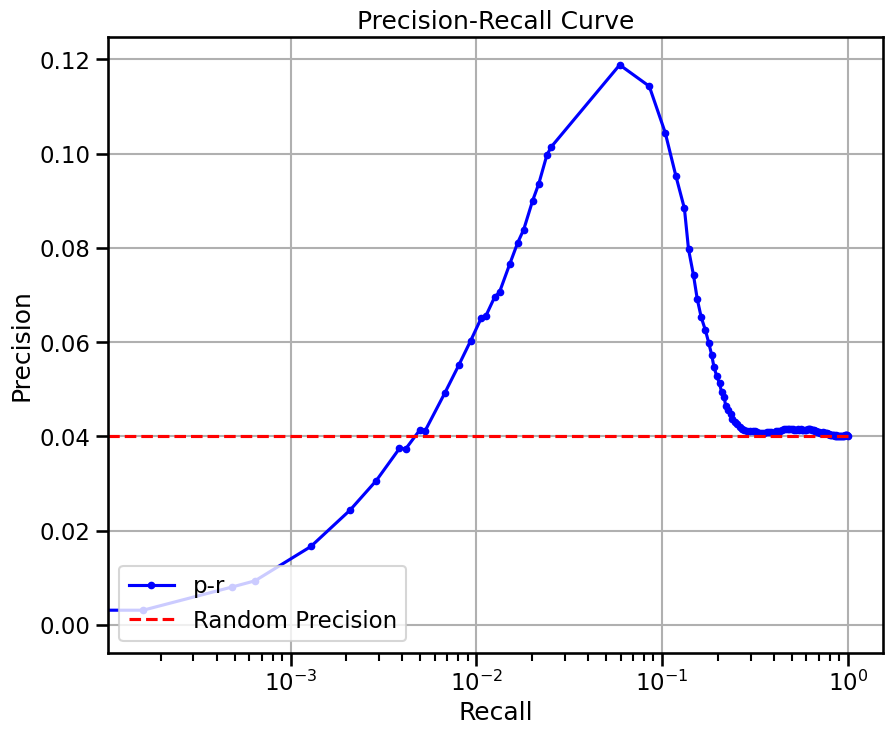

In [38]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.20101723344966588 
recall:  1.0 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 57%|█████▋    | 73/128 [00:00<00:00, 728.42it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 727.15it/s]

Area Under Precision-Recall Curve (AUPRC):  0.22212306997073636
EPR: 1.1545745762979105


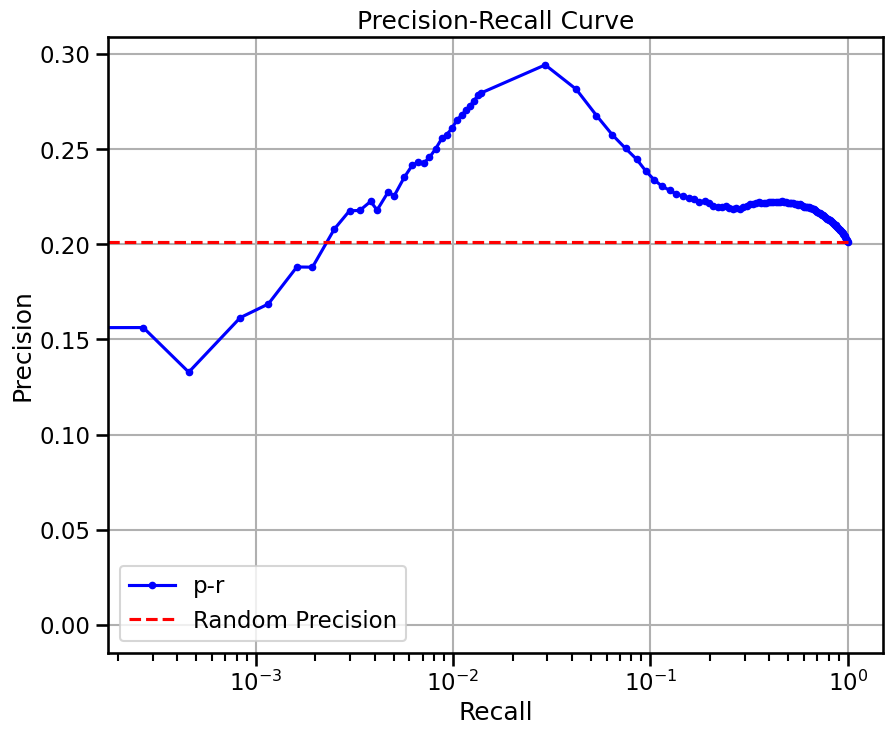

In [39]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_mean_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0857875419278928 
recall:  1.0 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 35%|███▌      | 45/128 [00:00<00:00, 440.20it/s]


 70%|███████   | 90/128 [00:00<00:00, 438.98it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 436.58it/s]

Area Under Precision-Recall Curve (AUPRC):  0.09120739461514557
EPR: 1.2424369659578294


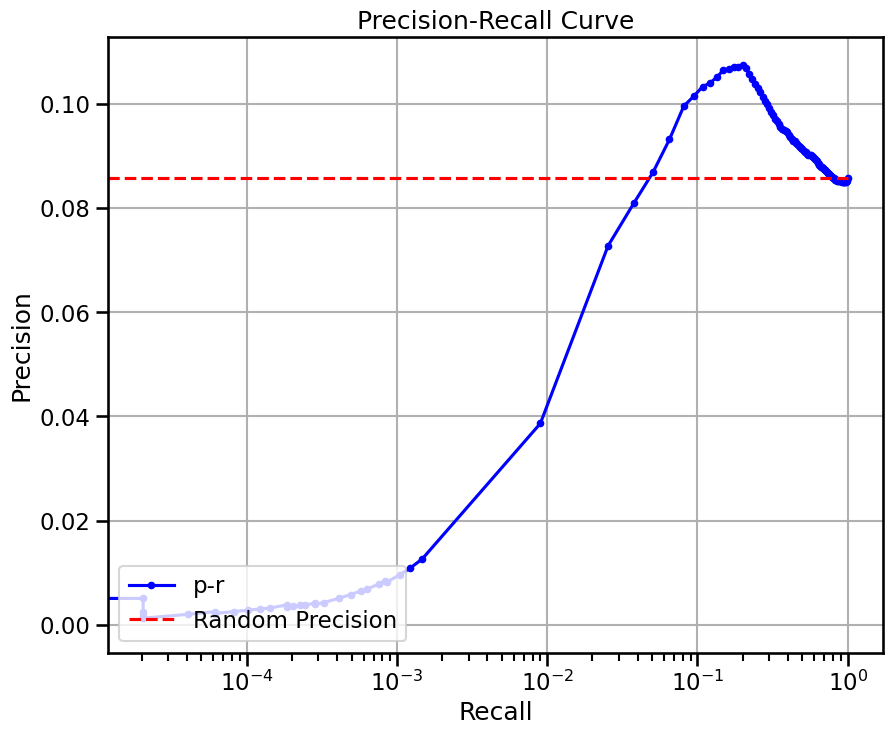

In [40]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_mean_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [41]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2197.39it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03507049926875483
EPR: 0.35342160541497697


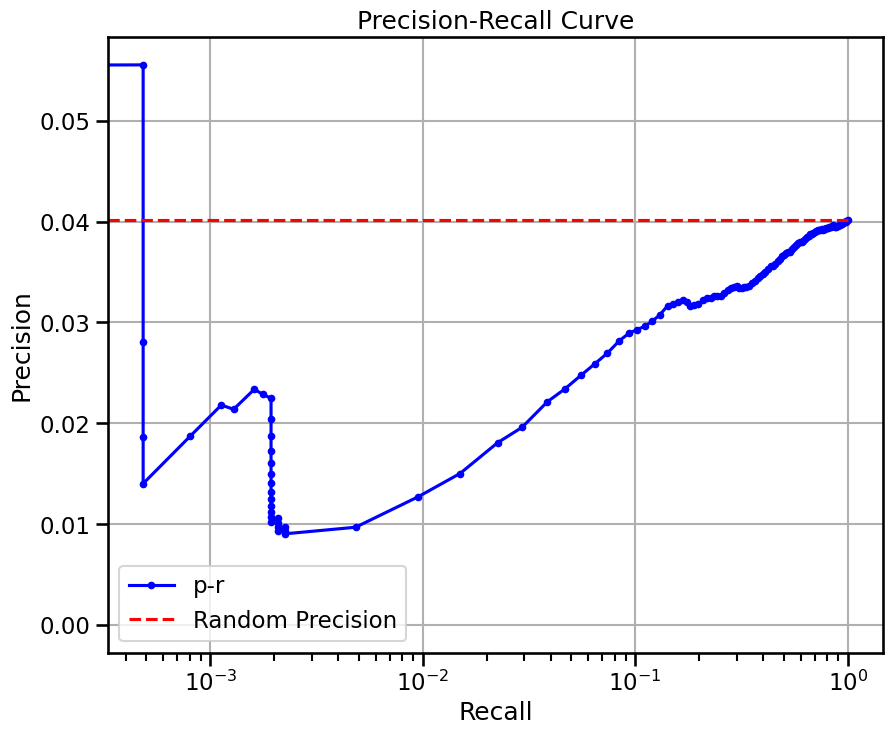

In [42]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.20101723344966588 
recall:  1.0 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 715.24it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 713.13it/s]

Area Under Precision-Recall Curve (AUPRC):  0.17286084513795724
EPR: 0.6536411636393383


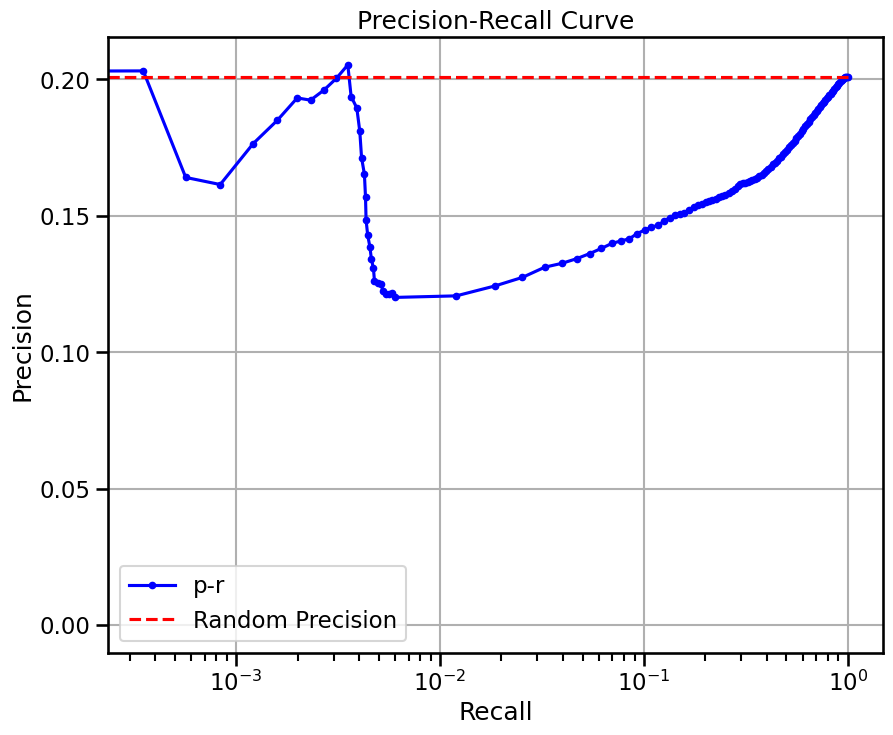

In [43]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_omni_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0857875419278928 
recall:  1.0 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 34%|███▎      | 43/128 [00:00<00:00, 423.14it/s]


 67%|██████▋   | 86/128 [00:00<00:00, 423.22it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 424.10it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0921408209225231
EPR: 1.363780460855781


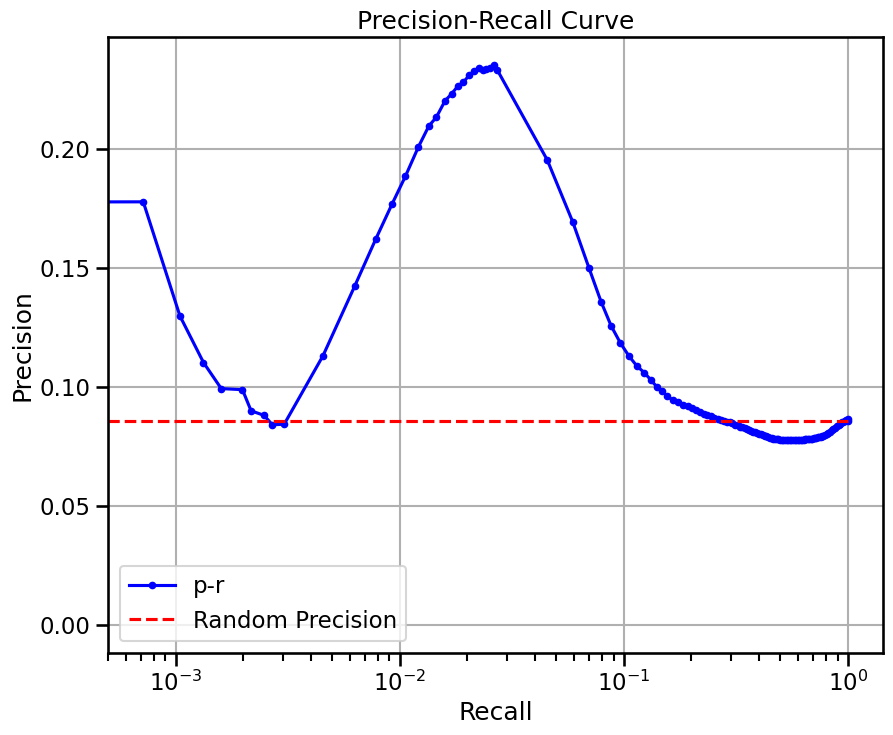

In [44]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_omni_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2189.92it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03207834097261386
EPR: 0.15314050058188136


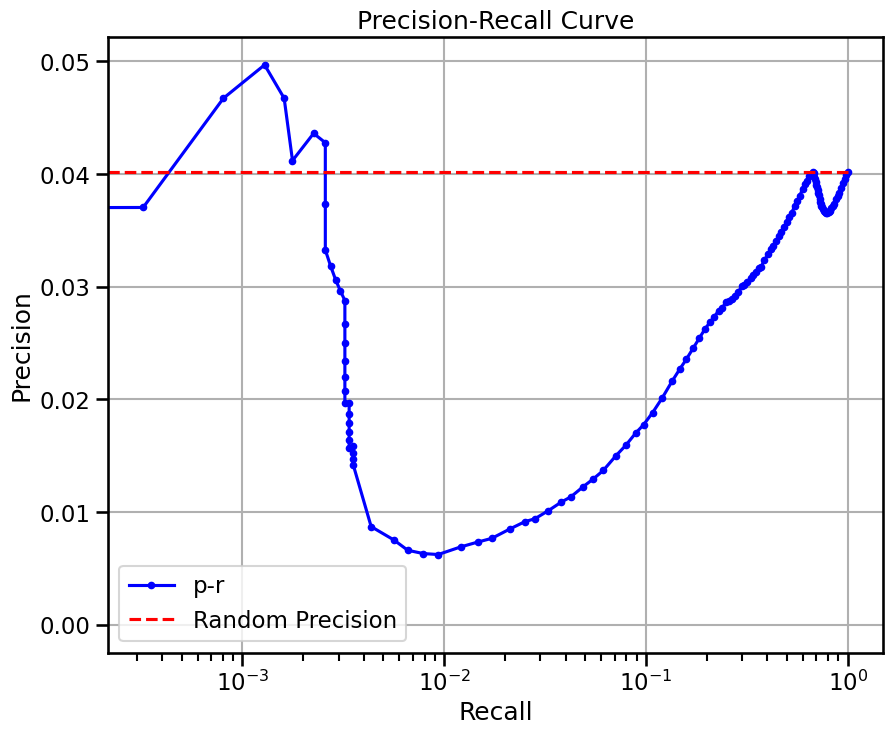

In [45]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.20101723344966588 
recall:  1.0 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 57%|█████▋    | 73/128 [00:00<00:00, 721.10it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 718.14it/s]

Area Under Precision-Recall Curve (AUPRC):  0.21097195869579188
EPR: 1.1673107543618428


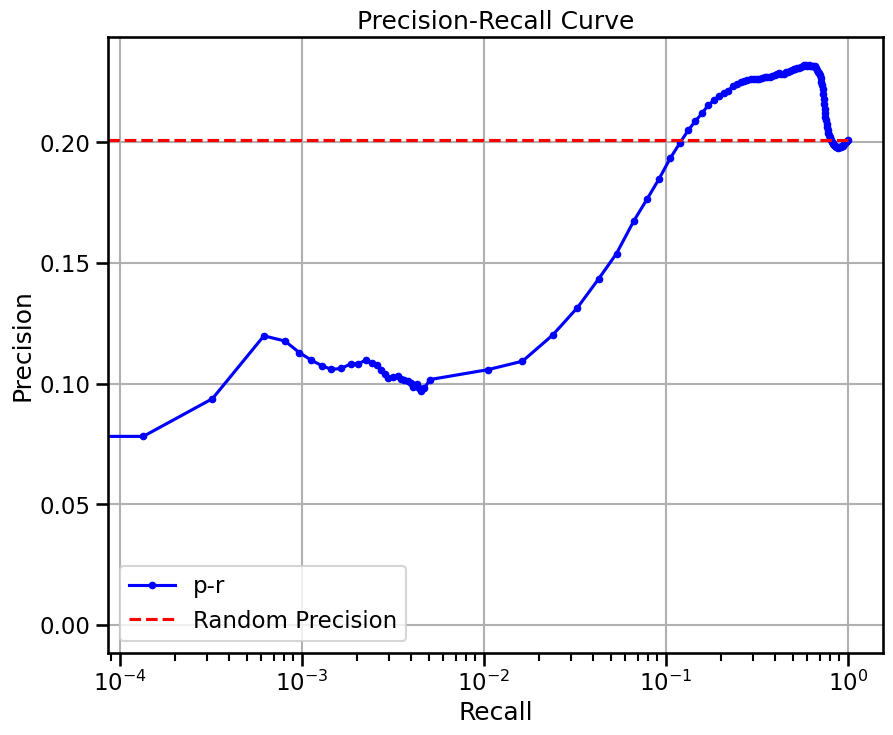

In [46]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_self_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0857875419278928 
recall:  1.0 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 34%|███▎      | 43/128 [00:00<00:00, 425.74it/s]


 67%|██████▋   | 86/128 [00:00<00:00, 425.92it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 425.37it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08185525466221996
EPR: 0.5736779352103518


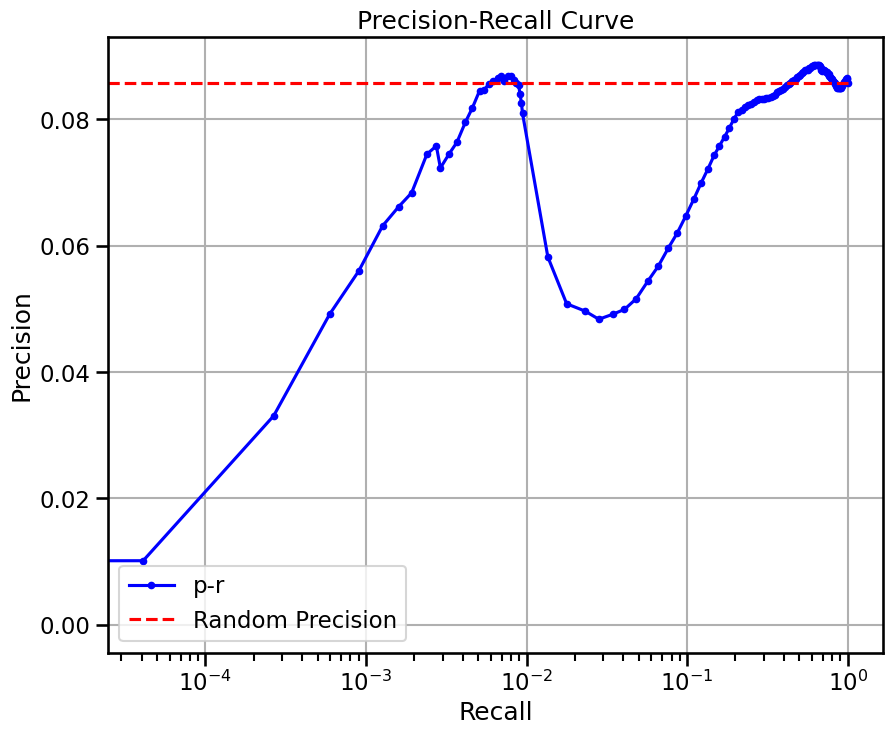

In [47]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_self_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [48]:
del grn

## zhao / mouse

In [49]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 36199 renamining


filtered out 0 cells, 36199 renamining


Removed 0 genes.


startin QC


Seeing 828 outliers (2.29% of total dataset):


done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

In [50]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.0392254862760778 
recall:  1.0 
random precision: 0.03923332980462731



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2055.76it/s]

Area Under Precision-Recall Curve (AUPRC):  0.042887701150062324
EPR: 0.24449026595628415


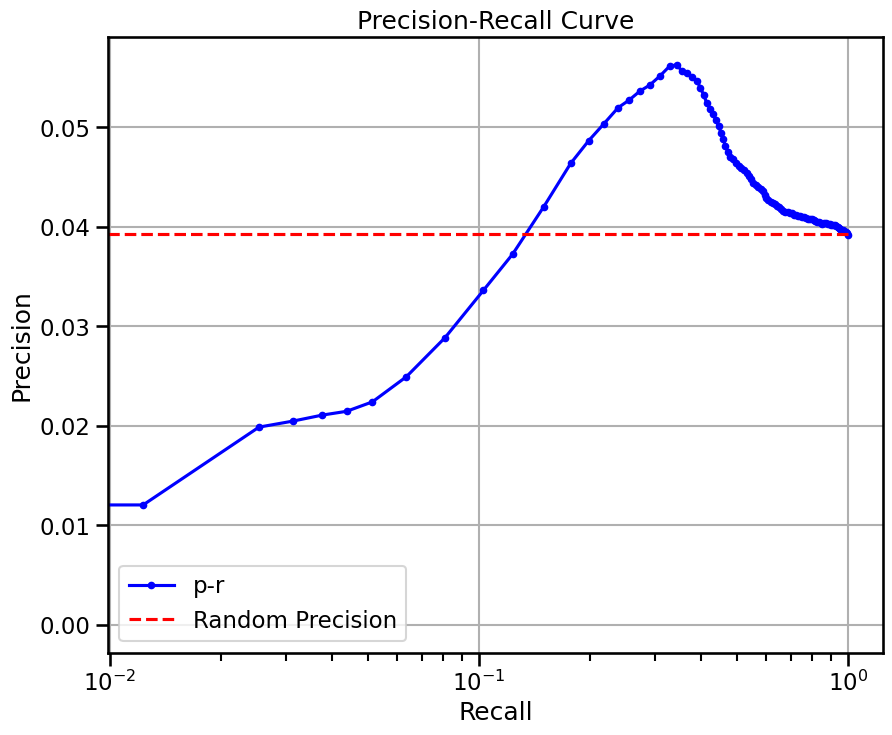

In [52]:
grn.varp['GRN'] = grn.varp['all'].mean(-1).T
metrics['scprint_mean_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0392254862760778 
recall:  1.0 
random precision: 0.03923332980462731



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 1990.67it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03470883023970331
EPR: 0.48413199324644557


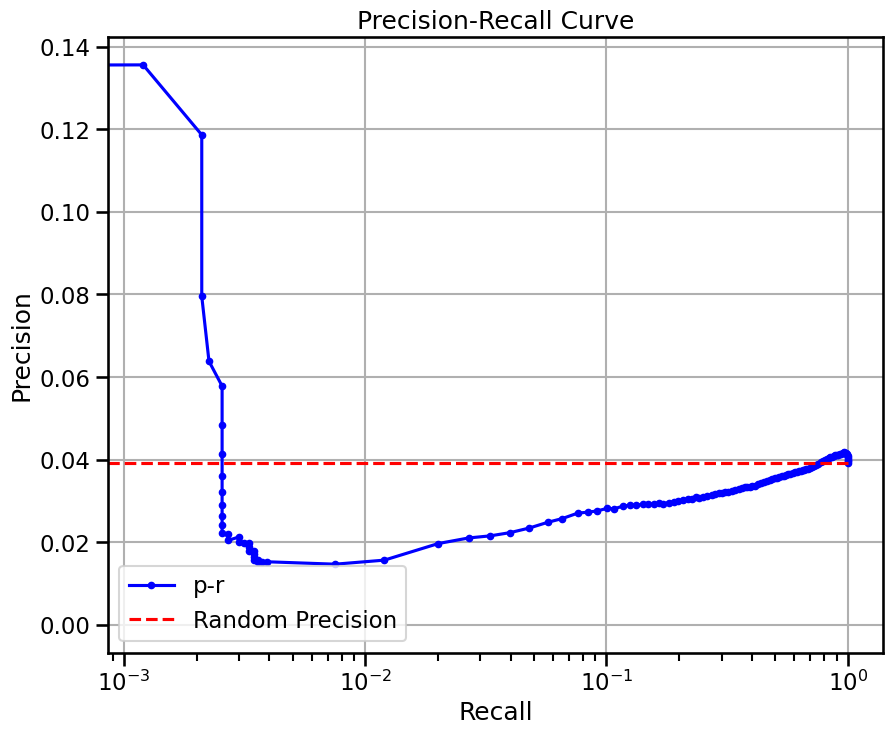

In [53]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_omni_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.04670264983427216 
recall:  1.0 
random precision: 0.046715764872136314



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2819.29it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03790911745987571
EPR: 0.087347440749958


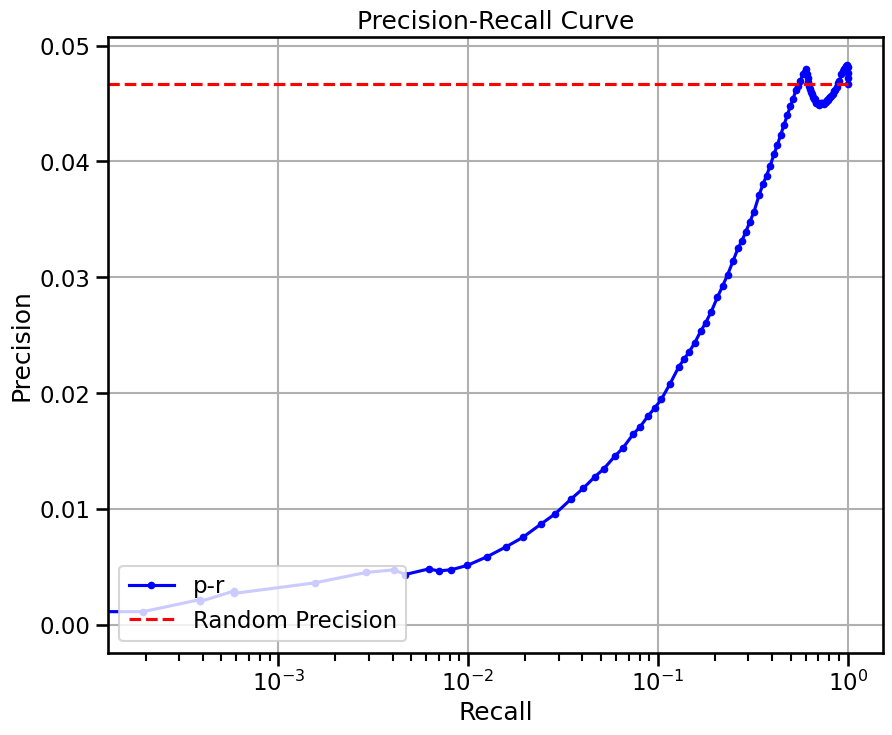

In [54]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1].T
metrics['scprint_self_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [1]:
metrics = {'scprint_mean_han_full': {'precision': 0.04014336917562724,
  'recall': 1.0,
  'rand_precision': 0.04015140749544615,
  'auprc': 0.05066923677336137,
  'epr': 2.9838291137924227},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Adipose progenitor cells',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Granulocytes',
   'celltype.gmt__Neutrophils',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Trophoblast cells',
   'celltype.gmt__Endothelial cell',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Extracellular matrix cells'],
  'significant_enriched_TFtargets': 23.636363636363637,
  'precision': 0.0016151890916386552,
  'recall': 1.0,
  'rand_precision': 0.001615617978811156,
  'auprc': 0.0018056727840080483,
  'epr': 2.0321305173018605},
 'scprint_mean_han_chip': {'precision': 0.20101723344966588,
  'recall': 1.0,
  'rand_precision': 0.20105748519845437,
  'auprc': 0.22212306997073636,
  'epr': 1.1545745762979105},
 'scprint_mean_han_ko': {'precision': 0.0857875419278928,
  'recall': 1.0,
  'rand_precision': 0.08580472005002494,
  'auprc': 0.09120739461514557,
  'epr': 1.2424369659578294},
 'scprint_omni_han_full': {'precision': 0.038948387096774194,
  'recall': 1.0,
  'rand_precision': 0.03895617833244068,
  'auprc': 0.05101876149961283,
  'epr': 4.779300230434627},
 'scprint_omni_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['0__TFs'],
  'significant_enriched_TFtargets': 3.6363636363636362,
  'precision': 0.0016151890916386552,
  'recall': 1.0,
  'rand_precision': 0.001615617978811156,
  'auprc': 0.0016597335453934078,
  'epr': 5.116867859465253},
 'scprint_omni_han_chip': {'precision': 0.264192,
  'recall': 1.0,
  'rand_precision': 0.26424484896979394,
  'auprc': 0.24434708945360423,
  'epr': 0.7665527604309154},
 'scprint_omni_han_ko': {'precision': 0.08270819672131148,
  'recall': 1.0,
  'rand_precision': 0.0827247416696454,
  'auprc': 0.07761441980402883,
  'epr': 0.7330050915595431},
 'scprint_self_han_full': {'precision': 0.08270819672131148,
  'recall': 1.0,
  'rand_precision': 0.0827247416696454,
  'auprc': 0.175334226332792,
  'epr': 3.785081109470365},
 'scprint_self_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Enterocytes',
   'celltype.gmt__Ductal cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Alpha cells',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Peri-islet Schwann cells',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Radial glial cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Enteric glia cells',
   'celltype.gmt__Endothelial cell',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Astrocytes',
   'celltype.gmt__Distal tubule cells',
   'celltype.gmt__Retinal progenitor cells',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Proximal tubule cells',
   'celltype.gmt__Progenitor cells',
   'celltype.gmt__Foveolar cells',
   'celltype.gmt__Glial cells',
   'celltype.gmt__Hepatoblasts',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Melanocytes',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Mature neurons',
   'celltype.gmt__Keratinocytes',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Beta cells',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Lymphatic Endothelial cells',
   'celltype.gmt__Gamma (PP) cells',
   'celltype.gmt__Neural Progenitor cells',
   'celltype.gmt__Cone bipolar cells',
   'celltype.gmt__Myoepithelial cells',
   'celltype.gmt__Myoblasts',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Goblet cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Gastric chief cells',
   'celltype.gmt__Neuronal cells',
   'celltype.gmt__Ionocytes',
   'celltype.gmt__Erythroid-like and erythroid precursor cells',
   'celltype.gmt__Neural stem cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Cap mesenchyme cells (Mesenchymal cells)',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesothelial cells',
   'celltype.gmt__Starburst amacrine cells',
   'celltype.gmt__Enterochromaffin cells',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Crypt cells',
   'celltype.gmt__Retinal pigment epithelial cells',
   'celltype.gmt__Renal interstitium (Mesenchymal cells)'],
  'significant_enriched_TFtargets': 12.727272727272727,
  'precision': 0.0016151890916386552,
  'recall': 1.0,
  'rand_precision': 0.001615617978811156,
  'auprc': 0.001591941934779904,
  'epr': 0.9450126925343056},
 'scprint_self_han_chip': {'precision': 0.264192,
  'recall': 1.0,
  'rand_precision': 0.26424484896979394,
  'auprc': 0.26014067801461294,
  'epr': 0.9227285790989448},
 'scprint_self_han_ko': {'precision': 0.08270819672131148,
  'recall': 1.0,
  'rand_precision': 0.0827247416696454,
  'auprc': 0.175334226332792,
  'epr': 3.785081109470365},
 'scprint_mean_mine_full': {'precision': 0.02702970952160392,
  'recall': 1.0,
  'rand_precision': 0.0270359707468811,
  'auprc': 0.024383016589726053,
  'epr': 0.03432789372232627},
 'scprint_mean_mine_base': {'enriched_terms_Central': ['celltype.gmt__Tuft cells'],
  'significant_enriched_TFtargets': 31.11111111111111,
  'precision': 0.001610920679194184,
  'recall': 1.0,
  'rand_precision': 0.0016114869079039184,
  'auprc': 0.0018737308840721056,
  'epr': 1.763995803294471},
 'scprint_omni_mine_full': {'precision': 0.02702970952160392,
  'recall': 1.0,
  'rand_precision': 0.0270359707468811,
  'auprc': 0.041503188248301556,
  'epr': 2.5779886804780276},
 'scprint_omni_mine_base': {'enriched_terms_Central': ['celltype.gmt__Tuft cells'],
  'enriched_terms_Targets': ['celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Enterocytes',
   'celltype.gmt__Myoepithelial cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Alveolar macrophages',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__HSC/MPP cells',
   'celltype.gmt__Ventricular cardiomyocytes',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Pulmonary alveolar type II cells',
   'celltype.gmt__Hepatoblasts',
   'celltype.gmt__Progenitor cells',
   'celltype.gmt__Distal tubule cells',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Ductal cells',
   'celltype.gmt__Neutrophils',
   'celltype.gmt__Satellite cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Astrocytes',
   'celltype.gmt__Sebocytes',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Keratinocytes',
   'celltype.gmt__Melanocytes',
   'celltype.gmt__Basal cells (Airway progenitor cells)',
   'celltype.gmt__Epithelial cells'],
  'enriched_terms_Regulators': ['celltype.gmt__Spermatids', '0__TFs'],
  'significant_enriched_TFtargets': 6.666666666666667,
  'precision': 0.001610920679194184,
  'recall': 1.0,
  'rand_precision': 0.0016114869079039184,
  'auprc': 0.0015571916797868536,
  'epr': 0.569912751818765},
 'scprint_omni_tran_full': {'precision': 0.04014336917562724,
  'recall': 1.0,
  'rand_precision': 0.04015140749544615,
  'auprc': 0.03507049926875483,
  'epr': 0.35342160541497697},
 'scprint_omni_tran_chip': {'precision': 0.20101723344966588,
  'recall': 1.0,
  'rand_precision': 0.20105748519845437,
  'auprc': 0.17286084513795724,
  'epr': 0.6536411636393383},
 'scprint_omni_tran_ko': {'precision': 0.0857875419278928,
  'recall': 1.0,
  'rand_precision': 0.08580472005002494,
  'auprc': 0.0921408209225231,
  'epr': 1.363780460855781},
 'scprint_self_tran_full': {'precision': 0.04014336917562724,
  'recall': 1.0,
  'rand_precision': 0.04015140749544615,
  'auprc': 0.03207834097261386,
  'epr': 0.15314050058188136},
 'scprint_self_tranan_chip': {'precision': 0.20101723344966588,
  'recall': 1.0,
  'rand_precision': 0.20105748519845437,
  'auprc': 0.21097195869579188,
  'epr': 1.1673107543618428},
 'scprint_self_tran_ko': {'precision': 0.0857875419278928,
  'recall': 1.0,
  'rand_precision': 0.08580472005002494,
  'auprc': 0.08185525466221996,
  'epr': 0.5736779352103518},
 'scprint_mean_zhao_full': {'precision': 0.0392254862760778,
  'recall': 1.0,
  'rand_precision': 0.03923332980462731,
  'auprc': 0.042887701150062324,
  'epr': 0.24449026595628415},
 'scprint_omni_zhao_full': {'precision': 0.0392254862760778,
  'recall': 1.0,
  'rand_precision': 0.03923332980462731,
  'auprc': 0.03470883023970331,
  'epr': 0.48413199324644557},
 'scprint_self_zhao_full': {'precision': 0.04670264983427216,
  'recall': 1.0,
  'rand_precision': 0.046715764872136314,
  'auprc': 0.03790911745987571,
  'epr': 0.087347440749958}}

In [55]:
metrics

{'scprint_mean_han_full': {'precision': 0.04014336917562724,
  'recall': 1.0,
  'rand_precision': 0.04015140749544615,
  'auprc': 0.05066923677336137,
  'epr': 2.9838291137924227},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Adipose progenitor cells',
   'cellty

In [2]:
import pandas as pd

In [11]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append(["_".join(k.split('_')[-3:-1]), v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append(["_".join(k.split('_')[-3:-2])+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append(["_".join(k.split('_')[-3:-2])+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append(["_".join(k.split('_')[-3:-1]), v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,mean_han,2.983829,0.050669,0.040151,False
1,mean_chip,1.154575,0.222123,0.201057,False
2,mean_ko,1.242437,0.091207,0.085805,False
3,omni_han,4.779300,0.051019,0.038956,False
4,omni_chip,0.766553,0.244347,0.264245,False
5,omni_ko,0.733005,0.077614,0.082725,False
6,self_han,3.785081,0.175334,0.082725,False
7,self_chip,0.922729,0.260141,0.264245,False
8,self_ko,3.785081,0.175334,0.082725,False
9,mean_mine,0.034328,0.024383,0.027036,False


In [12]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,mean_han,2.032131,0.001806,0.001616,23.636364,True,False
1,omni_han,5.116868,0.001660,0.001616,3.636364,True,False
2,self_han,0.945013,0.001592,0.001616,12.727273,True,False
3,mean_mine,1.763996,0.001874,0.001611,31.111111,False,False
4,omni_mine,0.569913,0.001557,0.001611,6.666667,False,False
